In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, expr
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import (
    RandomForestRegressor as SparkRandomForestRegressor,
    GBTRegressor as SparkGBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from xgboost.spark import SparkXGBRegressor
from pyspark.sql.functions import corr, avg, stddev
from pyspark.ml.classification import MultilayerPerceptronClassifier

from builtins import min as py_min, max as py_max, sum as py_sum

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .config("spark.driver.memory", "8g") \
       .config("spark.executor.memory", "8g") \
       .config("spark.sql.adaptive.enabled", "true") \
       .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
       .config("spark.sql.shuffle.partitions", "8") \
       .getOrCreate()

spark

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,594 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,799 kB]
Fetched 5,653 kB in 4s (1,263 k

In [ ]:
spark

In [ ]:
import requests

file_url = "https://raw.githubusercontent.com/duonghieu7104/Trend-Analysis-Aviation-Industry-US/main/data/US%20Airline%20Flight%20Routes%20and%20Fares%201993-2024.csv"
file_name = "US Airline Flight Routes and Fares 1993-2024.csv"

print(f"Downloading data from {file_url}...")
!wget -O "{file_name}" "{file_url}"

print("Loading data with multiLine option...")

df = spark.read \
    .option("header", "true") \
    .option("multiLine", "true") \
    .option("inferSchema", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .csv(file_name)

df1 = df.select("*")

print(f"Data loaded successfully!")
print(f"Dataset shape: ({df.count():,} rows, {len(df.columns)} columns)")
print(f"Columns: {df.columns}")

# Show first few rows
print("\nFirst 5 rows:")
df.show(5, truncate=False)

# Show data types
print("\nData types:")
df.printSchema()

--2025-10-24 06:45:02--  https://raw.githubusercontent.com/duonghieu7104/Trend-Analysis-Aviation-Industry-US/main/data/US%20Airline%20Flight%20Routes%20and%20Fares%201993-2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63039765 (60M) [text/plain]
Saving to: ‘US Airline Flight Routes and Fares 1993-2024.csv’

US Airline Flight R 100%[===================>]  60.12M   110MB/s    in 0.5s    

2025-10-24 06:45:03 (110 MB/s) - ‘US Airline Flight Routes and Fares 1993-2024.csv’ saved [63039765/63039765]

Loading data with multiLine option...
Data loaded successfully!
Dataset shape: (245,955 rows, 23 columns)
Columns: ['tbl', 'Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'airportid_1', 'airportid_2', 'airport_1', 'airport_2', 'nsmi

# 1.Data Cleanning & Preprocessing

        Column  Missing_Count  Missing_Percentage
Geocoded_City2          39206           15.940314
Geocoded_City1          39206           15.940314
      fare_low           1612            0.655404
         lf_ms           1612            0.655404
   carrier_low           1612            0.655404
       fare_lg           1540            0.626131
      large_ms           1540            0.626131
    carrier_lg           1540            0.626131
           tbl              0            0.000000
    passengers              0            0.000000
          fare              0            0.000000
       nsmiles              0            0.000000
          Year              0            0.000000
     airport_2              0            0.000000
     airport_1              0            0.000000
   airportid_2              0            0.000000
   airportid_1              0            0.000000
         city2              0            0.000000
         city1              0            0.000000


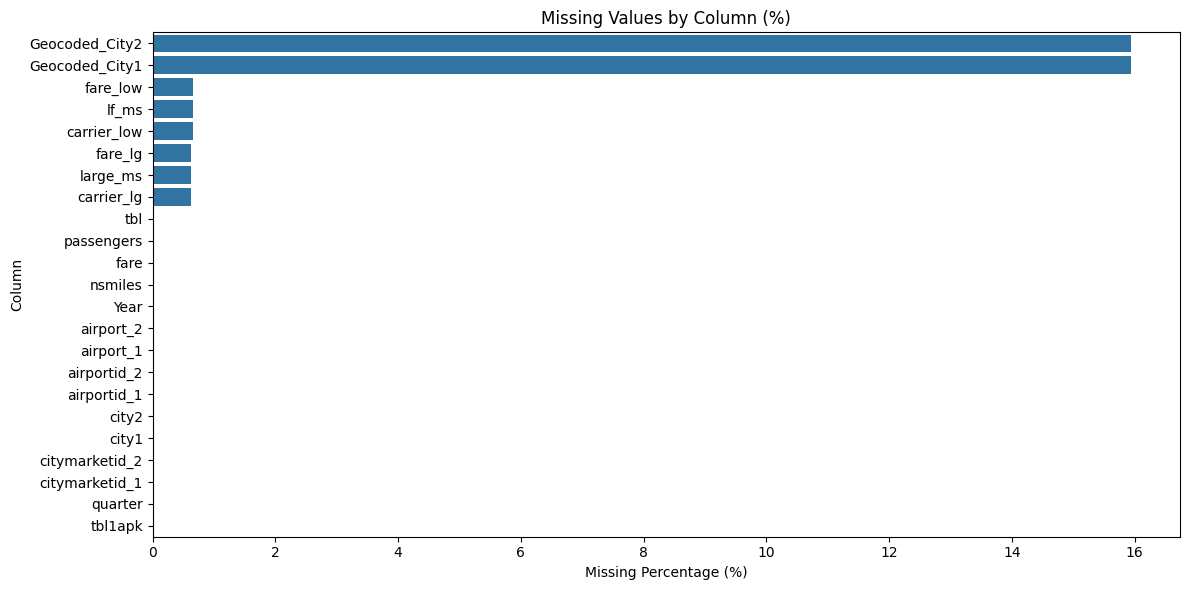

In [ ]:
# Missing values analysis
missing_data = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns
]).collect()[0].asDict()

missing_df = pd.DataFrame(list(missing_data.items()), columns=['Column', 'Missing_Count'])
missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / df.count()) * 100
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

print(missing_df.to_string(index=False))

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='Missing_Percentage', y='Column')
plt.title('Missing Values by Column (%)')
plt.xlabel('Missing Percentage (%)')
plt.tight_layout()
plt.show()


In [ ]:
#Remove rows with null target variable
df_clean = df.filter(col('large_ms').isNotNull())
print(df_clean.count())

244415


In [ ]:
#Filter valid market share values (0-1)
df_clean = df_clean.filter((col('large_ms') >= 0) & (col('large_ms') <= 1))
print(df_clean.count())

244415


In [ ]:
#Remove invalid business metrics
df_clean = df_clean.filter(
    (col('passengers') > 0) &
    (col('fare') > 0) &
    (col('nsmiles') > 0)
)
print(df_clean.count())

238057


In [ ]:
#Remove rows with missing carrier information
df_clean = df_clean.dropna(subset=['carrier_low'])
print(df_clean.count())

237985


In [ ]:
#Remove extreme outliers (using IQR method)
numeric_cols = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']
for col_name in numeric_cols:
    if col_name in df_clean.columns:
        # Calculate IQR
        quantiles = df_clean.select(
            expr(f"percentile_approx({col_name}, 0.25)").alias("q1"),
            expr(f"percentile_approx({col_name}, 0.75)").alias("q3")
        ).collect()[0]

        q1, q3 = quantiles['q1'], quantiles['q3']
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        df_clean = df_clean.filter(
            (col(col_name) >= lower_bound) & (col(col_name) <= upper_bound)
        )
print(df_clean.count())

211133


In [ ]:
df_clean.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c + "_nulls") for c in df_clean.columns
]).show()

+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+-----------+--------------+--------------------+--------------------+-------------+
|tbl_nulls|Year_nulls|quarter_nulls|citymarketid_1_nulls|citymarketid_2_nulls|city1_nulls|city2_nulls|airportid_1_nulls|airportid_2_nulls|airport_1_nulls|airport_2_nulls|nsmiles_nulls|passengers_nulls|fare_nulls|carrier_lg_nulls|large_ms_nulls|fare_lg_nulls|carrier_low_nulls|lf_ms_nulls|fare_low_nulls|Geocoded_City1_nulls|Geocoded_City2_nulls|tbl1apk_nulls|
+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+----

# 2.Exploratory Data Analysis (EDA)

In [ ]:
# Sample data for EDA
sample_size = 50000
df_sample = df_clean.sample(fraction=sample_size/df_clean.count(), seed=42).toPandas()

print(len(df_sample))

# Basic statistics
print(df_sample.describe().round(2))


50107
           Year   quarter  citymarketid_1  citymarketid_2  airportid_1  \
count  50107.00  50107.00        50107.00        50107.00     50107.00   
mean    2008.46      2.49        31563.83        32206.46     12443.02   
std        8.66      1.12         1105.95         1251.62      1432.50   
min     1993.00      1.00        30135.00        30189.00     10135.00   
25%     2001.00      1.00        30721.00        30994.00     11193.00   
50%     2008.00      2.00        31295.00        32337.00     12266.00   
75%     2016.00      3.00        32467.00        33195.00     13485.00   
max     2024.00      4.00        35412.00        35412.00     16440.00   

       airportid_2   nsmiles  passengers      fare  large_ms   fare_lg  \
count     50107.00  50107.00    50107.00  50107.00  50107.00  50107.00   
mean      13239.66   1189.68      173.93    216.27      0.67    215.71   
std        1431.13    697.69      196.95     67.25      0.23     72.11   
min       10466.00    109.00   

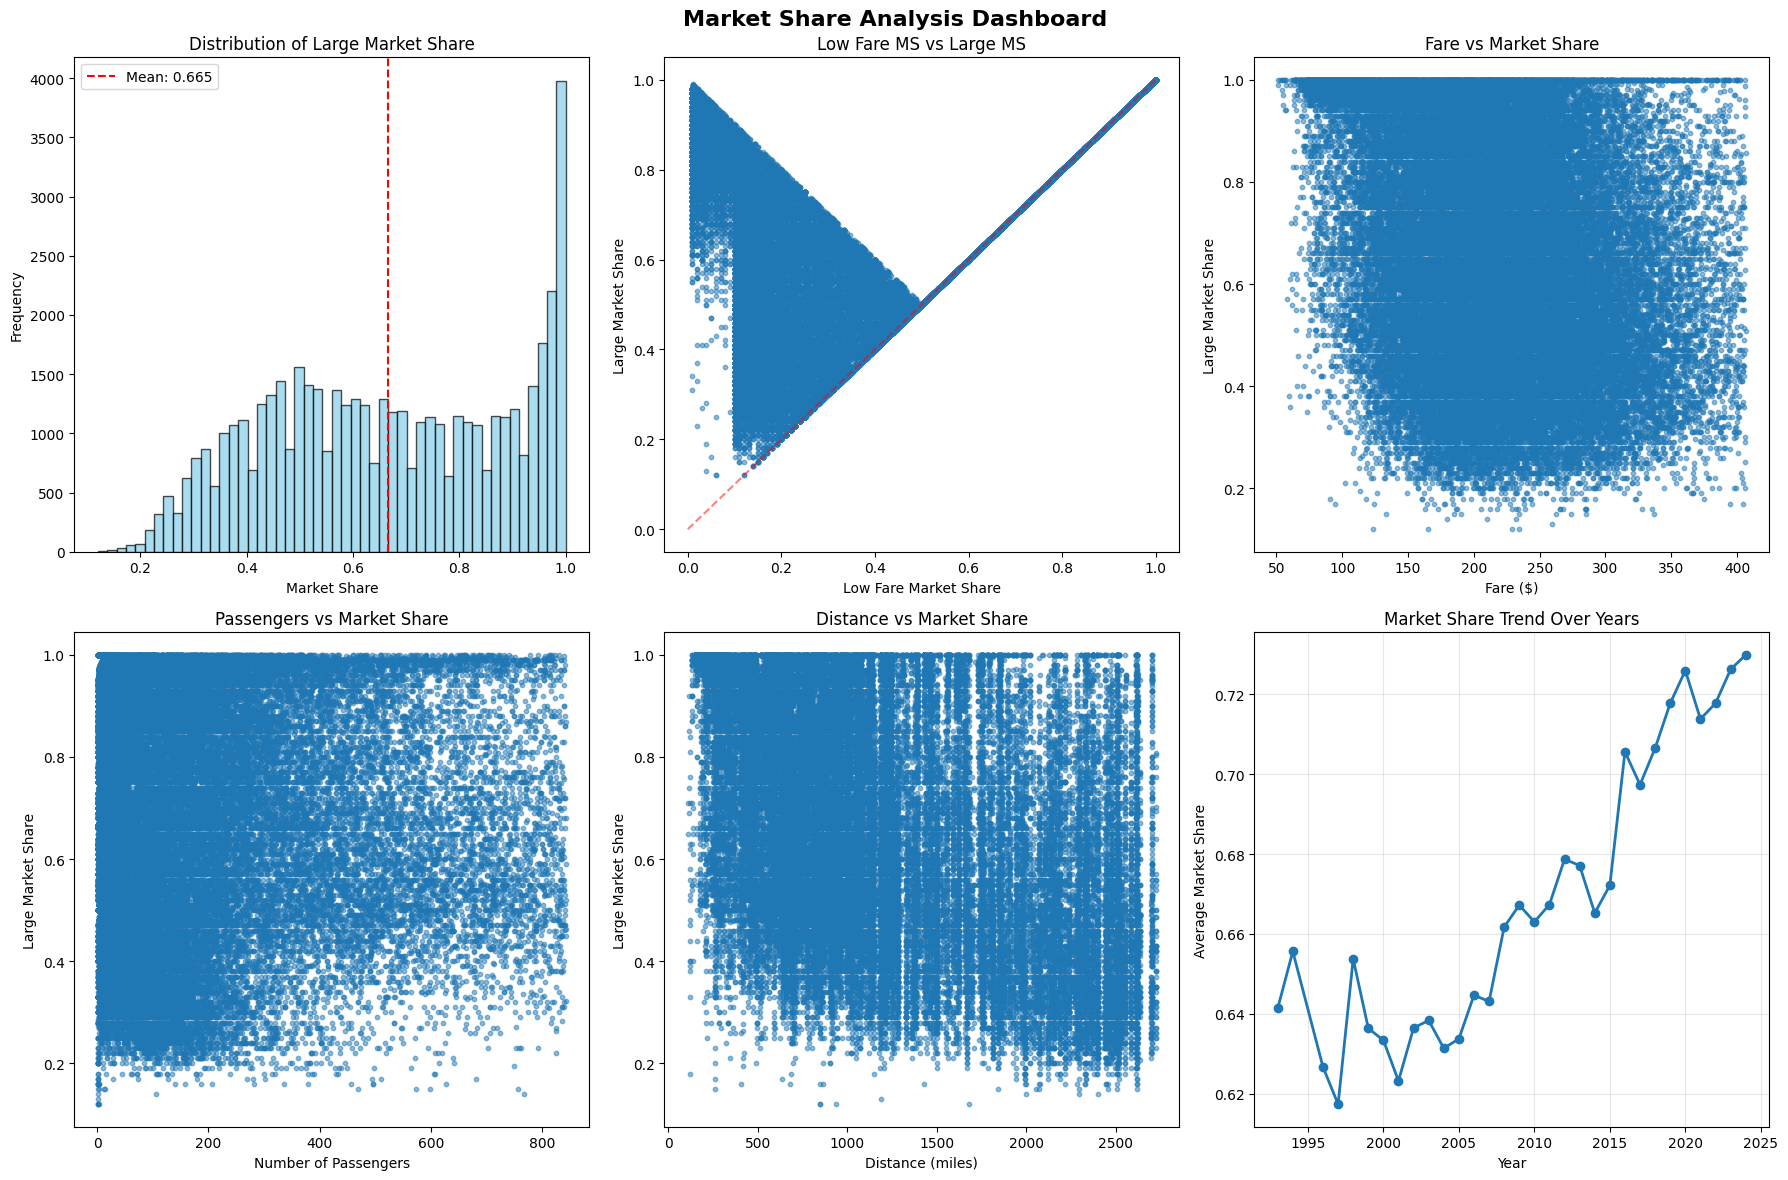

In [ ]:
# Market Share Distribution Analysis
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Market Share Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Market Share Distribution
axes[0,0].hist(df_sample['large_ms'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Large Market Share')
axes[0,0].set_xlabel('Market Share')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df_sample['large_ms'].mean(), color='red', linestyle='--',
                  label=f'Mean: {df_sample["large_ms"].mean():.3f}')
axes[0,0].legend()

# 2. Low Fare Market Share vs Large Market Share
axes[0,1].scatter(df_sample['lf_ms'], df_sample['large_ms'], alpha=0.5, s=10)
axes[0,1].set_title('Low Fare MS vs Large MS')
axes[0,1].set_xlabel('Low Fare Market Share')
axes[0,1].set_ylabel('Large Market Share')
axes[0,1].plot([0, 1], [0, 1], 'r--', alpha=0.5)

# 3. Fare vs Market Share
axes[0,2].scatter(df_sample['fare'], df_sample['large_ms'], alpha=0.5, s=10)
axes[0,2].set_title('Fare vs Market Share')
axes[0,2].set_xlabel('Fare ($)')
axes[0,2].set_ylabel('Large Market Share')

# 4. Passengers vs Market Share
axes[1,0].scatter(df_sample['passengers'], df_sample['large_ms'], alpha=0.5, s=10)
axes[1,0].set_title('Passengers vs Market Share')
axes[1,0].set_xlabel('Number of Passengers')
axes[1,0].set_ylabel('Large Market Share')

# 5. Distance vs Market Share
axes[1,1].scatter(df_sample['nsmiles'], df_sample['large_ms'], alpha=0.5, s=10)
axes[1,1].set_title('Distance vs Market Share')
axes[1,1].set_xlabel('Distance (miles)')
axes[1,1].set_ylabel('Large Market Share')

# 6. Yearly Trend
yearly_avg = df_sample.groupby('Year')['large_ms'].mean()
axes[1,2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=6)
axes[1,2].set_title('Market Share Trend Over Years')
axes[1,2].set_xlabel('Year')
axes[1,2].set_ylabel('Average Market Share')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TOP 10 CARRIERS BY AVERAGE MARKET SHARE:
            Route_Count  Avg_Market_Share  MS_StdDev  Total_Passengers  Avg_Fare
carrier_lg                                                                      
P9                   17             1.000      0.000              1845    88.163
E9                    2             1.000      0.000                39   103.850
U5                   30             0.917      0.185              4474   119.983
PN                    3             0.877      0.180                45   107.837
G4                  505             0.870      0.223             58789   116.296
WV                   12             0.857      0.181              1302   105.098
RL                    1             0.850        NaN               275   137.270
U2                    3             0.847      0.035               207   100.677
9N                    6             0.838      0.195               283   118.663
TZ                  272             0.818      0.239             684

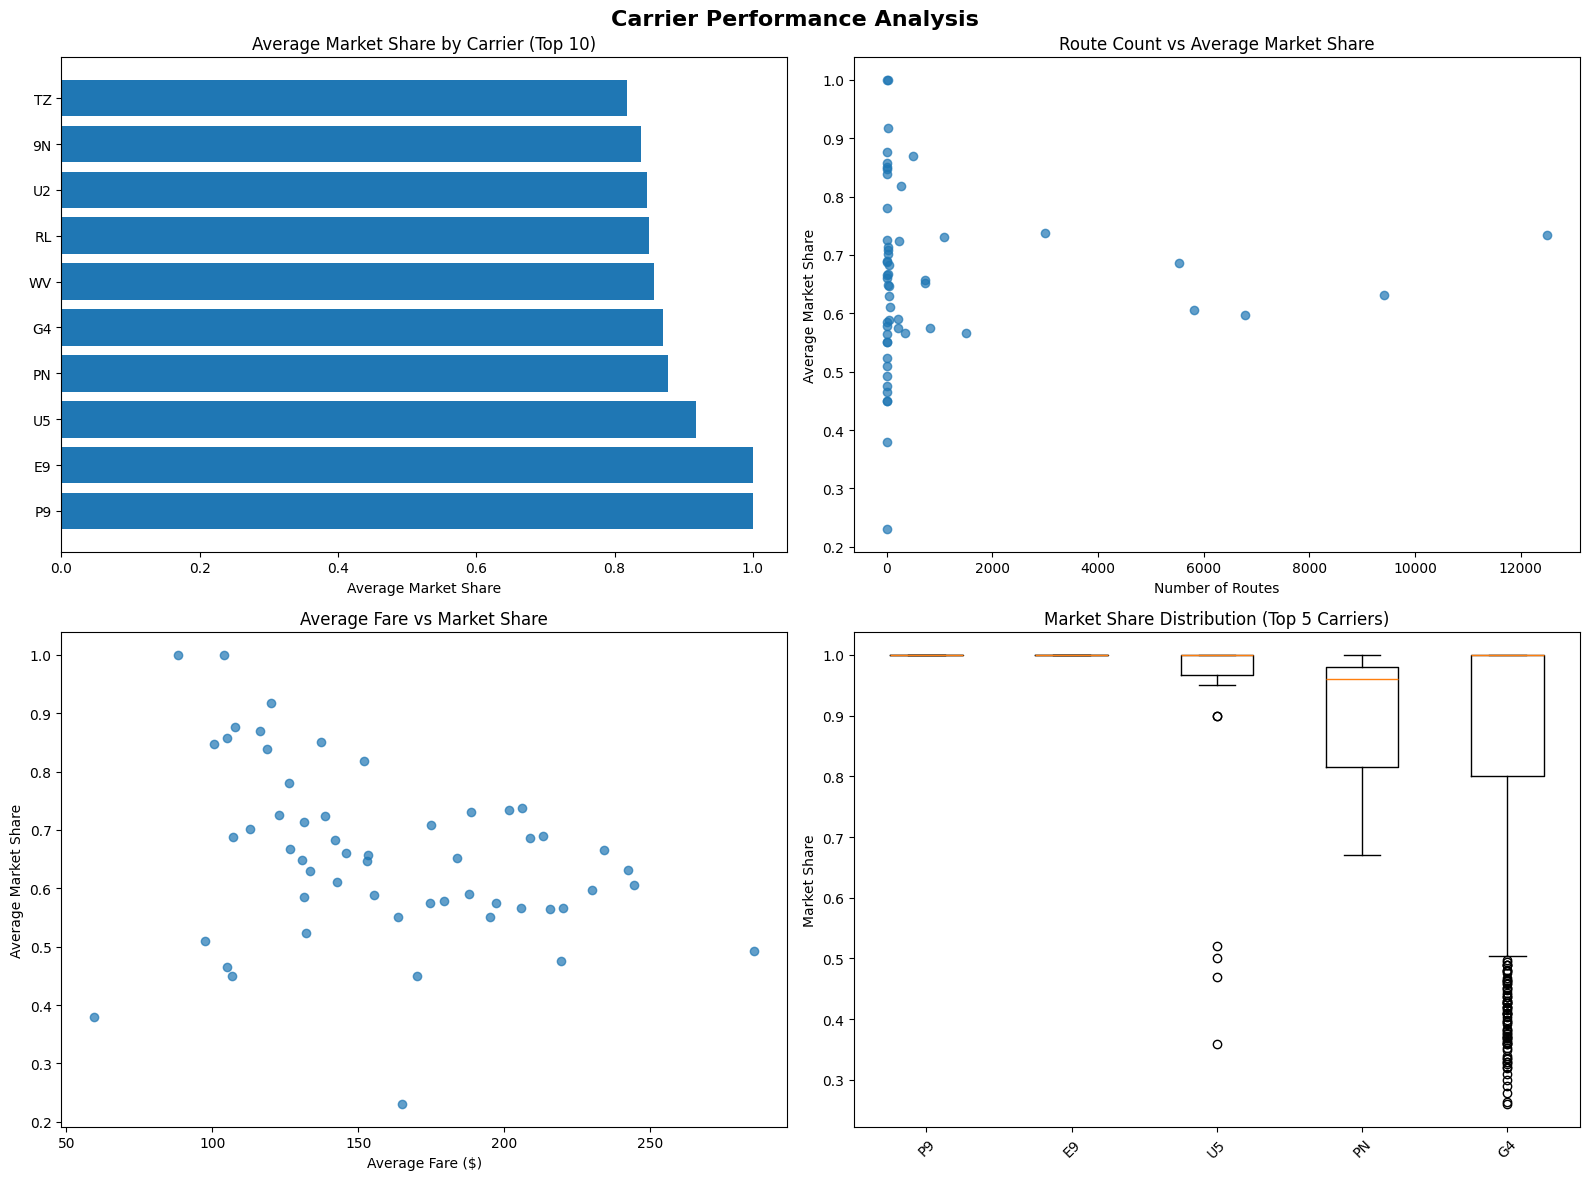

In [ ]:
# Carrier Analysis
# Top carriers by market share
carrier_stats = df_sample.groupby('carrier_lg').agg({
    'large_ms': ['count', 'mean', 'std'],
    'passengers': 'sum',
    'fare': 'mean'
}).round(3)

carrier_stats.columns = ['Route_Count', 'Avg_Market_Share', 'MS_StdDev', 'Total_Passengers', 'Avg_Fare']
carrier_stats = carrier_stats.sort_values('Avg_Market_Share', ascending=False)

print("TOP 10 CARRIERS BY AVERAGE MARKET SHARE:")
print(carrier_stats.head(10).to_string())

# Visualize carrier performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Carrier Performance Analysis', fontsize=16, fontweight='bold')

# 1. Market Share by Carrier (Top 10)
top_carriers = carrier_stats.head(10)
axes[0,0].barh(top_carriers.index, top_carriers['Avg_Market_Share'])
axes[0,0].set_title('Average Market Share by Carrier (Top 10)')
axes[0,0].set_xlabel('Average Market Share')

# 2. Route Count vs Market Share
axes[0,1].scatter(carrier_stats['Route_Count'], carrier_stats['Avg_Market_Share'], alpha=0.7)
axes[0,1].set_title('Route Count vs Average Market Share')
axes[0,1].set_xlabel('Number of Routes')
axes[0,1].set_ylabel('Average Market Share')

# 3. Fare vs Market Share
axes[1,0].scatter(carrier_stats['Avg_Fare'], carrier_stats['Avg_Market_Share'], alpha=0.7)
axes[1,0].set_title('Average Fare vs Market Share')
axes[1,0].set_xlabel('Average Fare ($)')
axes[1,0].set_ylabel('Average Market Share')

# 4. Market Share Distribution by Carrier
carrier_market_share = df_sample.groupby('carrier_lg')['large_ms'].apply(list)
top_5_carriers = carrier_stats.head(5).index
carrier_data = [carrier_market_share[carrier] for carrier in top_5_carriers]

axes[1,1].boxplot(carrier_data, labels=top_5_carriers)
axes[1,1].set_title('Market Share Distribution (Top 5 Carriers)')
axes[1,1].set_ylabel('Market Share')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Phân tích ảnh hưởng của khoảng cách đến giá vé

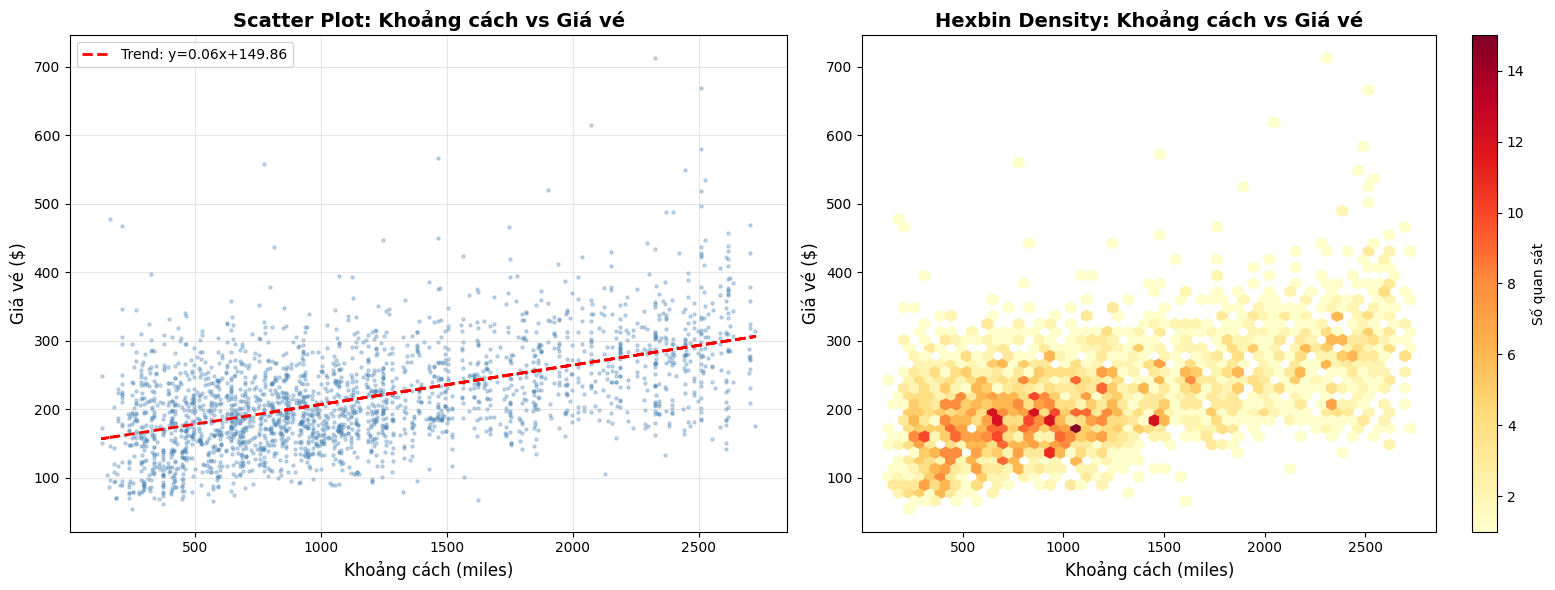


Hệ số tương quan Pearson: 0.5122


In [ ]:
# Mục đích: Trực quan hóa mối quan hệ giữa khoảng cách và giá vé

# Lấy mẫu dữ liệu
scatter_sample = df.select('nsmiles', 'fare').sample(False, sample_size, seed=42).toPandas()

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot thông thường
axes[0].scatter(scatter_sample['nsmiles'], scatter_sample['fare'],
                alpha=0.3, s=5, color='steelblue')
axes[0].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[0].set_ylabel('Giá vé ($)', fontsize=12)
axes[0].set_title('Scatter Plot: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Thêm đường xu hướng (trend line)
z = np.polyfit(scatter_sample['nsmiles'], scatter_sample['fare'], 1)
p = np.poly1d(z)
axes[0].plot(scatter_sample['nsmiles'], p(scatter_sample['nsmiles']),
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend(fontsize=10)

# 2. Hexbin plot (tốt hơn cho nhiều điểm)
hb = axes[1].hexbin(scatter_sample['nsmiles'], scatter_sample['fare'],
                     gridsize=50, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Hexbin Density: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
cb = plt.colorbar(hb, ax=axes[1])
cb.set_label('Số quan sát', fontsize=10)

plt.tight_layout()
plt.show()

# In tương quan
corr_distance_fare = df.stat.corr("nsmiles", "fare")
print(f"\nHệ số tương quan Pearson: {corr_distance_fare:.4f}")

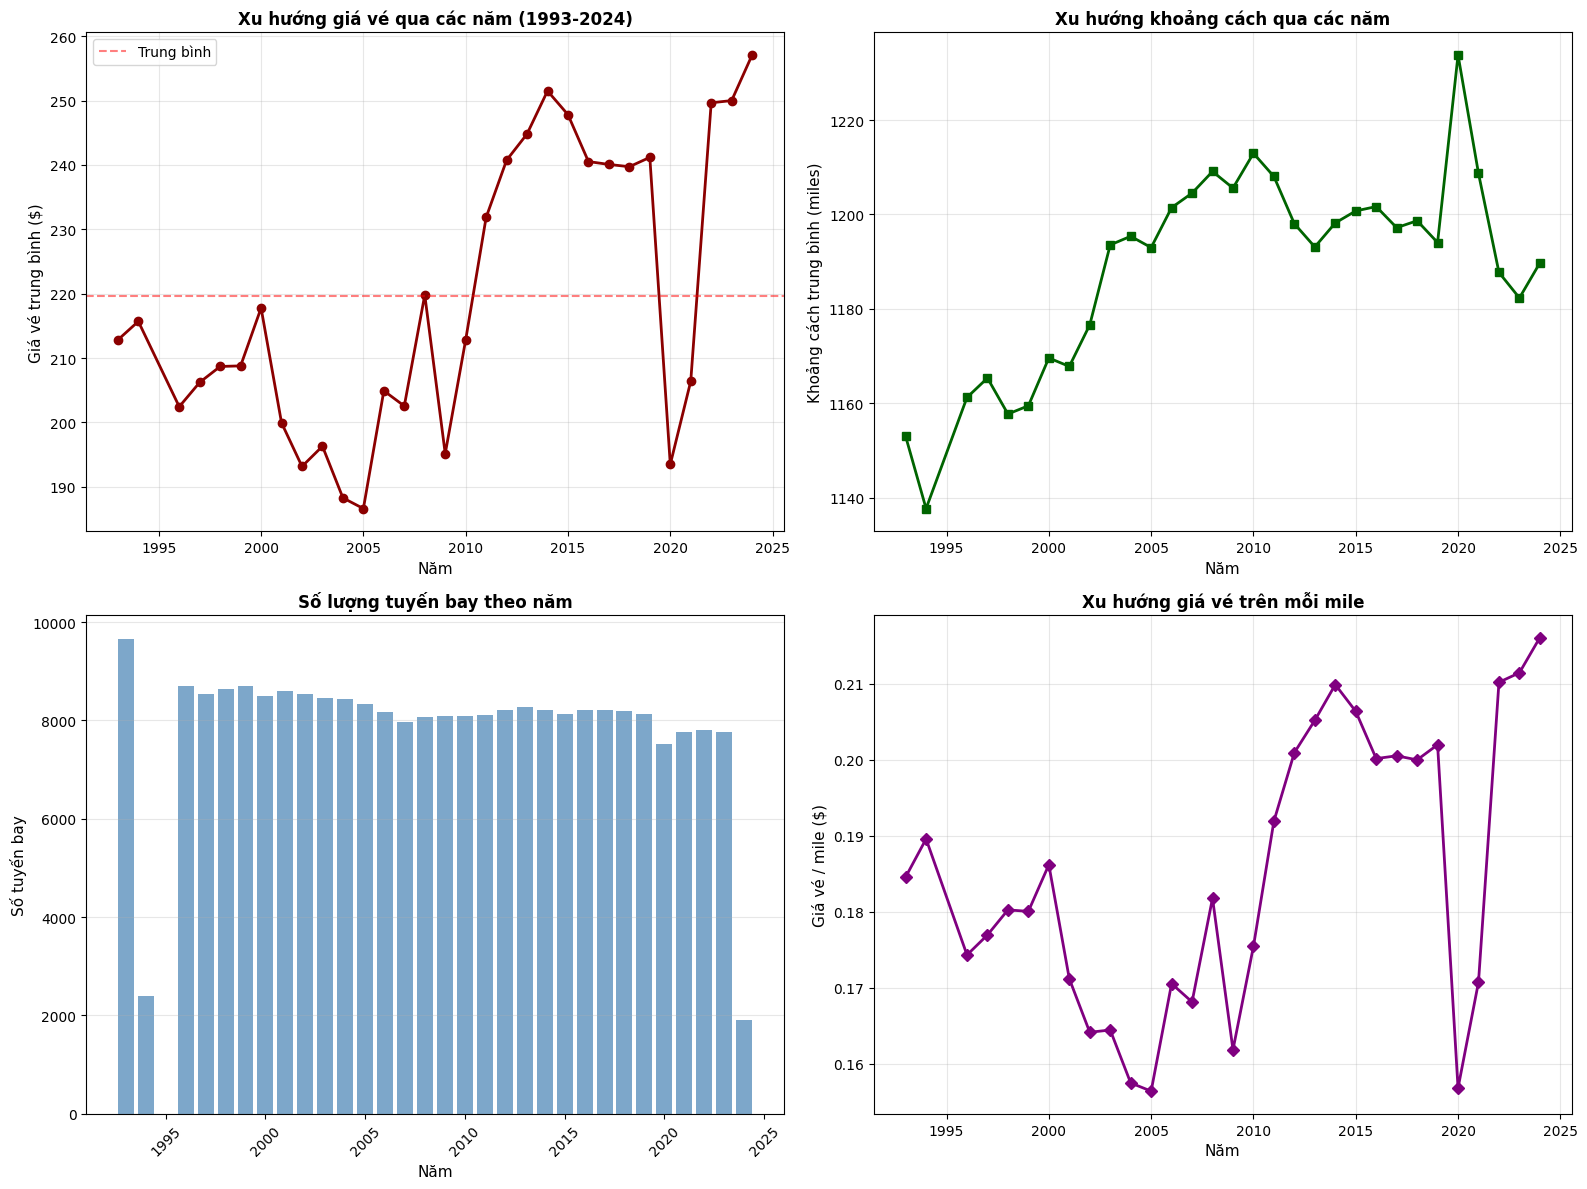

In [ ]:
# Tính trung bình theo năm
yearly_stats = df.groupBy('Year').agg(
    avg('fare').alias('gia_trung_binh'),
    avg('nsmiles').alias('khoang_cach_trung_binh'),
    avg('passengers').alias('hanh_khach_trung_binh'),
    count('*').alias('so_chuyen')
).orderBy('Year').toPandas()

# Tạo figure với 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Giá vé trung bình theo năm
axes[0, 0].plot(yearly_stats['Year'], yearly_stats['gia_trung_binh'],
                marker='o', linewidth=2, markersize=6, color='darkred')
axes[0, 0].set_xlabel('Năm', fontsize=11)
axes[0, 0].set_ylabel('Giá vé trung bình ($)', fontsize=11)
axes[0, 0].set_title('Xu hướng giá vé qua các năm (1993-2024)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=yearly_stats['gia_trung_binh'].mean(),
                    color='r', linestyle='--', alpha=0.5, label='Trung bình')
axes[0, 0].legend()

# 2. Khoảng cách trung bình theo năm
axes[0, 1].plot(yearly_stats['Year'], yearly_stats['khoang_cach_trung_binh'],
                marker='s', linewidth=2, markersize=6, color='darkgreen')
axes[0, 1].set_xlabel('Năm', fontsize=11)
axes[0, 1].set_ylabel('Khoảng cách trung bình (miles)', fontsize=11)
axes[0, 1].set_title('Xu hướng khoảng cách qua các năm', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Số chuyến bay theo năm
axes[1, 0].bar(yearly_stats['Year'], yearly_stats['so_chuyen'],
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Năm', fontsize=11)
axes[1, 0].set_ylabel('Số tuyến bay', fontsize=11)
axes[1, 0].set_title('Số lượng tuyến bay theo năm', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Giá vé trên mỗi mile
yearly_stats['gia_per_mile'] = yearly_stats['gia_trung_binh'] / yearly_stats['khoang_cach_trung_binh']
axes[1, 1].plot(yearly_stats['Year'], yearly_stats['gia_per_mile'],
                marker='D', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_xlabel('Năm', fontsize=11)
axes[1, 1].set_ylabel('Giá vé / mile ($)', fontsize=11)
axes[1, 1].set_title('Xu hướng giá vé trên mỗi mile', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3.Model Development & Training

## 3.1 Predict ticket prices and passenger volumes.

### 3.1.1 **Flight Fare Prediction Model**

In [ ]:
df1 = df1.drop("Geocoded_City1", "Geocoded_City2")

#  Thay null bằng "None" cho cột kiểu chuỗi
df1 = df1.withColumn("carrier_lg", when(col("carrier_lg").isNull(), "None").otherwise(col("carrier_lg")))
df1 = df1.withColumn("carrier_low", when(col("carrier_low").isNull(), "None").otherwise(col("carrier_low")))

# Thay null bằng 0 cho cột số
df1 = df1.fillna({"large_ms": 0, "lf_ms": 0})

# Fallback: nếu fare_lg hoặc fare_low bị null → dùng giá trị fare chung
df1 = df1.withColumn("fare_lg", when(col("fare_lg").isNull(), col("fare")).otherwise(col("fare_lg")))
df1 = df1.withColumn("fare_low", when(col("fare_low").isNull(), col("fare")).otherwise(col("fare_low")))



In [ ]:

# ---- 1. Chuyển kiểu dữ liệu ----
df1 = df1.withColumn("Year", col("Year").cast(IntegerType())) \
       .withColumn("quarter", col("quarter").cast(IntegerType())) \
       .withColumn("fare", col("fare").cast(DoubleType())) \
       .withColumn("fare_low", col("fare_low").cast(DoubleType()))

# ---- 2. Loại bỏ các cột không cần thiết ----
cols_to_drop = [c for c in ["Geocoded_City1", "Geocoded_City2", "tbl1apk", "city1", "city2"] if c in df1.columns]
df1 = df1.drop(*cols_to_drop)

# ---- 3. Loại bỏ null trong fare, passengers ----
df1 = df1.na.drop(subset=["fare", "passengers"])

# ---- 4. Tạo các feature mới ----
from pyspark.sql.functions import pow

if all(c in df1.columns for c in ["fare_lg", "fare_low"]):
    df1 = df1.withColumn("fare_diff", col("fare_lg") - col("fare_low"))

if all(c in df1.columns for c in ["large_ms", "lf_ms"]):
    df1 = df1.withColumn(
        "hhi",
        pow(col("large_ms"), 2)
        + pow(col("lf_ms"), 2)
        + pow(1 - (col("large_ms") + col("lf_ms")), 2)
    )

if "nsmiles" in df1.columns:
    df1 = df1.withColumn("fare_per_mile", when(col("nsmiles") != 0, col("fare") / col("nsmiles")).otherwise(None))

print(" Tiền xử lý xong:", df1.count(), "dòng,", len(df1.columns), "cột")


 Tiền xử lý xong: 245955 dòng, 21 cột


In [ ]:

# --------------------------
# 1️⃣ Chia cột và dữ liệu
# --------------------------
num_features = ["Year", "quarter", "nsmiles", "passengers", "fare_diff", "hhi", "fare_per_mile"]
cat_features = [c for c in df1.columns if c.startswith(("airport_", "carrier_"))]
target = "fare"

# --------------------------
# 2️⃣ Xử lý cột phân loại và scale
# --------------------------
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep") for c in cat_features]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in cat_features]

assembler_inputs = num_features + [c + "_vec" for c in cat_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# --------------------------
# 3️⃣ Chia dữ liệu Train/Test (dùng chung cho tất cả mô hình)
# --------------------------
train_df, test_df = df1.randomSplit([0.8, 0.2], seed=42)

print("Dữ liệu đã chia:")
print(f" - Train: {train_df.count()} dòng")
print(f" - Test:  {test_df.count()} dòng")



Dữ liệu đã chia:
 - Train: 196552 dòng
 - Test:  49403 dòng


#### Random Forest

In [ ]:

# --------------------------
# 1️⃣ Tạo Pipeline mô hình Random Forest
# --------------------------
rf = RandomForestRegressor(labelCol=target, featuresCol="scaledFeatures", seed=42)

# Pipeline gồm toàn bộ xử lý
rf_model = Pipeline(stages=indexers + encoders + [assembler, scaler, rf])

# --------------------------
# 2️⃣ Tập siêu tham số cần thử
# --------------------------
param_grid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50,100,200])
    .addGrid(rf.maxDepth, [10, 15])
    .build()
)

# --------------------------
# 3️⃣ TrainValidationSplit (thay vì CrossValidator)
# --------------------------
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

tvs = TrainValidationSplit(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,    # 80% train, 20% validation
    parallelism=4      # chạy song song 4 job
)

# --------------------------
# 4️⃣ Huấn luyện
# --------------------------
rf_tvs_model = tvs.fit(train_df)

# --------------------------
# 5️⃣ In thông tin mô hình tốt nhất
# --------------------------
best_rf = rf_tvs_model.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf._java_obj.getNumTrees())
print(" - maxDepth:", best_rf._java_obj.getMaxDepth())


Best Parameters Found:
 - numTrees: 200
 - maxDepth: 15


In [ ]:

# Sử dụng toàn bộ pipeline tốt nhất
train_pred = rf_tvs_model.bestModel.transform(train_df)
test_pred  = rf_tvs_model.bestModel.transform(test_df)


metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9621
R2 Test : 0.9482
----------
MAE Train: 9.5988
MAE Test : 10.4521
----------
MSE Train: 256.9823
MSE Test : 353.3241
----------


#### Gradient Boosted Tree

In [ ]:

# 1️⃣ Khai báo mô hình GBT (tương tự XGB)
gbt = GBTRegressor(
    labelCol=target,
    featuresCol="scaledFeatures",
    seed=42
)

# 2️⃣ Xây dựng pipeline (đã có bước xử lý trước: indexers, encoders, assembler, scaler)
xgb_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, gbt])

# 3️⃣ Tạo grid tham số để thử (tương tự param_dist_xgb)
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [4, 8])
    .addGrid(gbt.maxIter, [20, 40])   # tương đương n_estimators
    .addGrid(gbt.stepSize, [0.05, 0.1])  # tương đương learning_rate
    .build()
)

# 4️⃣ Đánh giá bằng R2
evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

# 5️⃣ Chia train/validation (tương tự RandomizedSearchCV)
tvs = TrainValidationSplit(
    estimator=xgb_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # 80% train, 20% validation
    parallelism=4,
    seed=42
)

# 6️⃣ Huấn luyện và chọn mô hình tốt nhất
xgb_tvs_model = tvs.fit(train_df)

# 7️⃣ In kết quả tốt nhất
best_gbt = xgb_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getOrDefault("maxDepth"))
print(" - maxIter:", best_gbt.getOrDefault("maxIter"))
print(" - stepSize:", best_gbt.getOrDefault("stepSize"))



Best Parameters Found:
 - maxDepth: 8
 - maxIter: 40
 - stepSize: 0.1


In [ ]:
train_pred = xgb_tvs_model.bestModel.transform(train_df)
test_pred  = xgb_tvs_model.bestModel.transform(test_df)

metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9736
R2 Test : 0.9656
----------
MAE Train: 7.6887
MAE Test : 7.9885
----------
MSE Train: 178.735
MSE Test : 234.3938
----------


#### Nhận xét

##### Hiệu suất tổng thể

Cả hai mô hình đều có **R² > 0.94**, tức là chúng giải thích được hơn **94% biến thiên của giá vé** → rất mạnh và có khả năng dự báo tốt.

Tuy nhiên, **GBT (Gradient Boosted Trees)** vượt trội hơn rõ rệt so với **Random Forest**:

| Mô hình | R² Train | R² Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9621 | 0.9482 | 9.5988 | 10.4521 | 256.9823 | 353.3241 |
| GBT | 0.9736 | 0.9656 | 7.6887 | 7.9885 | 178.735 | 234.3938 |

- GBT có **R² cao hơn** trên cả train và test → mô hình học tốt hơn.  
- **Sai số (MAE, MSE)** đều **thấp hơn** → dự đoán sát hơn với giá thực tế.  
**GBT Regression** là mô hình **tốt hơn** cho bài toán dự đoán giá vé .

##### Mức độ Overfitting (Quá khớp)

Chênh lệch R² giữa train và test rất nhỏ:

- **Random Forest:** 0.9621 → 0.9482 (**chênh 0.0139**)  
- **GBT:** 0.9736 → 0.9656 (**chênh 0.0080**)
- Không có dấu hiệu **overfitting nghiêm trọng**.  
- Mô hình tổng quát tốt và hoạt động ổn trên dữ liệu mới.  
**Kết luận:** Cả hai mô hình đều không bị overfit, và **GBT** còn **tổng quát tốt hơn**.


##### Sai số trung bình

- Với **MAE ≈ 8 (GBT)** → mô hình dự đoán **lệch trung bình khoảng 8 đơn vị tiền tệ** (USD, nghìn đồng,... tuỳ dữ liệu gốc).  
- Nếu giá vé thực tế dao động ở mức hàng trăm trở lên → đây là **mức sai số rất nhỏ**, hoàn toàn **chấp nhận được** trong ứng dụng thực tế.

##### Tổng kết

- **Mô hình tốt nhất:** `GBT Regression`  
- **Ưu điểm:** chính xác, ổn định, ít overfit.  
- **Khả năng ứng dụng:** cao trong dự đoán giá vé chuyến bay thực tế.  


 Top 5 feature quan trọng nhất:
         feature  importance
2        nsmiles    0.465169
6  fare_per_mile    0.414281
0           Year    0.026063
3     passengers    0.019350
5            hhi    0.003930


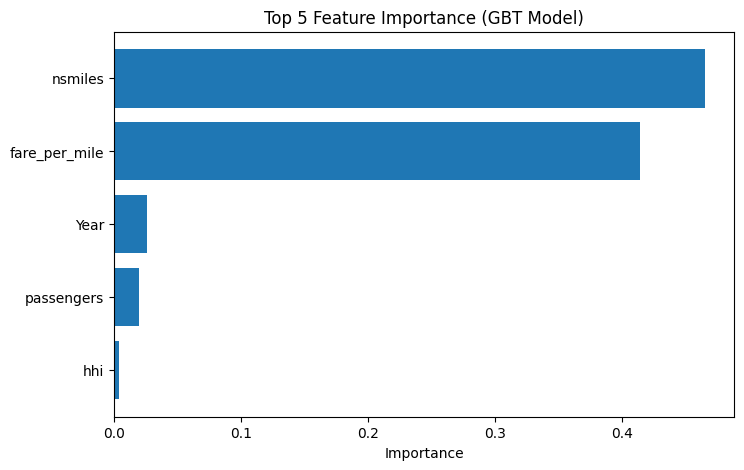

In [ ]:
from pyspark.ml import PipelineModel
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Load pipeline model
# ===============================
pipeline_model = PipelineModel.load("/content/drive/MyDrive/models/gbt_best_model")

# ===============================
# 2️⃣ Lấy stage cuối (GBT model)
# ===============================
gbt_model = pipeline_model.stages[-1]

# ===============================
# 3️⃣ Tìm stage VectorAssembler
# ===============================
assembler = None
for stage in pipeline_model.stages:
    if stage.__class__.__name__ == "VectorAssembler":
        assembler = stage
        break

if assembler is None:
    raise ValueError("Không tìm thấy VectorAssembler trong pipeline!")

assembler_inputs = assembler.getInputCols()

# ===============================
# 4️⃣ Lấy danh sách feature thực tế (expand OneHot)
# ===============================
expanded_feature_names = []

for stage in pipeline_model.stages:
    # Nếu là OneHotEncoder
    if stage.__class__.__name__ == "OneHotEncoder":
        input_col = stage.getInputCol()
        output_col = stage.getOutputCol()

        # Lấy metadata từ outputCol (số chiều vector)
        try:
            attr_metadata = df.schema[output_col].metadata["ml_attr"]["attrs"]
            attr_names = []
            for attr_type in attr_metadata:
                for item in attr_metadata[attr_type]:
                    attr_names.append(item["name"])
            expanded_feature_names.extend(attr_names)
        except Exception:
            # Nếu không có metadata, thêm tên chung
            expanded_feature_names.append(output_col)

    # Nếu là cột numeric (hoặc cột không cần mã hoá)
    elif stage.__class__.__name__ == "VectorAssembler":
        continue

# Thêm các cột numeric trực tiếp
for c in assembler_inputs:
    if not c.endswith("_vec"):
        expanded_feature_names.append(c)

# ===============================
# 5️⃣ Lấy importance từ model
# ===============================
importances = gbt_model.featureImportances.toArray()

# Cắt hoặc khớp độ dài nếu chênh lệch nhỏ
min_len = min(len(importances), len(expanded_feature_names))
importances = importances[:min_len]
expanded_feature_names = expanded_feature_names[:min_len]

# ===============================
# 6️⃣ Tạo DataFrame và sắp xếp
# ===============================
feature_importance_df = pd.DataFrame({
    "feature": expanded_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# ===============================
# 7️⃣ In top 5 feature quan trọng nhất
# ===============================
print(" Top 5 feature quan trọng nhất:")
print(feature_importance_df.head(5))

# ===============================
# 8️⃣ (Tuỳ chọn) Vẽ biểu đồ
# ===============================
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df.head(top_n)["feature"], feature_importance_df.head(top_n)["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importance (GBT Model)")
plt.show()


### 3.1.2 **Flight Passenger Prediction Model**

In [ ]:

# Xử lý dữ liệu cơ bản
# =========================================

df1 = (
    df1.withColumn("Year", F.col("Year").cast("int"))
      .withColumn("quarter", F.col("quarter").cast("int"))
      .withColumn("fare", F.col("fare").cast("double"))
      .withColumn("fare_low", F.col("fare_low").cast("double"))
)

# Loại bỏ dòng thiếu fare hoặc passengers
df1 = df1.na.drop(subset=["fare", "passengers"])

# Loại bỏ cột không cần thiết
drop_cols = ["tbl", "city1", "city2", "Geocoded_City1", "Geocoded_City2", "airport_1", "airport_2"]
for c in drop_cols:
    if c in df1.columns:
        df1 = df1.drop(c)

# =========================================
# Feature Engineering
# =========================================

# Season theo quarter
df1 = df1.withColumn(
    "season",
    F.when(F.col("quarter") == 1, "Spring")
     .when(F.col("quarter") == 2, "Summer")
     .when(F.col("quarter") == 3, "Fall")
     .when(F.col("quarter") == 4, "Winter")
)

# route_id = airportid_1 + "_" + airportid_2
df1 = df1.withColumn("route_id", F.concat_ws("_", F.col("airportid_1").cast("string"), F.col("airportid_2").cast("string")))

# fare_diff
if "fare_lg" in df1.columns and "fare_low" in df1.columns:
    df1 = df1.withColumn("fare_diff", F.col("fare_lg") - F.col("fare_low"))

# HHI index
if all(col in df1.columns for col in ["large_ms", "lf_ms"]):
    df1 = df1.withColumn(
        "hhi",
        F.pow(F.col("large_ms"), 2)
        + F.pow(F.col("lf_ms"), 2)
        + F.pow(1 - (F.col("large_ms") + F.col("lf_ms")), 2)
    )

# fare_per_mile
df1 = df1.withColumn("fare_per_mile", F.col("fare") / F.col("nsmiles"))

# =========================================
# Lag Features (theo route_id, Year, quarter)
# =========================================

window_spec = Window.partitionBy("route_id").orderBy("Year", "quarter")

df1 = df1.withColumn("passengers_lag1", F.lag("passengers", 1).over(window_spec))
df1 = df1.withColumn("passengers_lag4", F.lag("passengers", 4).over(window_spec))

# Rolling mean (4 kỳ trước)
window_roll = Window.partitionBy("route_id").orderBy("Year", "quarter").rowsBetween(-4, -1)
df1 = df1.withColumn("passengers_roll_mean4", F.avg("passengers").over(window_roll))
df1 = df1.withColumn("passengers_roll_median4", F.expr("percentile_approx(passengers, 0.5)").over(window_roll))
df1 = df1.na.drop(subset=["passengers_lag1","passengers_lag4","passengers_roll_mean4","passengers_roll_median4"])

# =========================================
# Encode categorical (Label Encoding)
# =========================================

cat_cols = ["carrier_lg", "carrier_low", "season", "route_id"]

for c in cat_cols:
    if c in df1.columns:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
        df1 = indexer.fit(df1).transform(df1).drop(c).withColumnRenamed(f"{c}_index", c)

# =========================================
# Kết quả
# =========================================

print(f"Kích thước dataframe sau feature engineering: {df1.count()} hàng × {len(df1.columns)} cột")

print("Các cột mới:")
for c in df1.columns:
    if any(k in c for k in ["lag", "roll", "season"]):
        print("-", c)

Kích thước dataframe sau feature engineering: 231269 hàng × 25 cột
Các cột mới:
- passengers_lag1
- passengers_lag4
- passengers_roll_mean4
- passengers_roll_median4
- season


In [ ]:

# ======================================
# Chọn features + target
# ======================================

target = "passengers"

# Áp dụng log1p để giảm skew giống sklearn
df1 = df1.withColumn("log_passengers", F.log1p(F.col("passengers")))

# Các features
num_features = [
    "Year", "quarter", "fare", "fare_low", "fare_diff", "hhi",
    "fare_per_mile", "passengers_lag1", "passengers_lag4",
    "passengers_roll_mean4", "passengers_roll_median4", "nsmiles","carrier_lg", "carrier_low", "season", "route_id"
]

# ======================================
# Tách train/test
# ======================================
train_df, test_df = df1.randomSplit([0.8, 0.2], seed=42)

# ======================================
# Chuẩn hóa dữ liệu (StandardScaler)
# ======================================

# Gộp feature numeric vào 1 vector
assembler = VectorAssembler(inputCols=num_features, outputCol="features_vec")

# Chuẩn hóa tương tự StandardScaler
scaler = StandardScaler(inputCol="features_vec", outputCol="scaledFeatures")


#### Random Forest

In [ ]:
rf1 = RandomForestRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf1])

# ======================================
# Tập siêu tham số (giống param_dist sklearn)
# ======================================

param_grid = (
    ParamGridBuilder()
    .addGrid(rf1.numTrees, [50,70,100])
    .addGrid(rf1.maxDepth, [5,10])
    .build()
)

# ======================================
# Tách train/test
# ======================================

train_df, test_df = df1.randomSplit([0.8, 0.2], seed=42)

# ======================================
# TrainValidationSplit (thay cho RandomizedSearchCV)
# ======================================

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs1 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,      # 80% train / 20% validation
    parallelism=4,       # chạy song song
    seed=42
)

# ======================================
# Huấn luyện mô hình
# ======================================

tvs_model1 = tvs1.fit(train_df)

# In thông tin mô hình tốt nhất
# --------------------------
best_rf1 = tvs_model1.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf1._java_obj.getNumTrees())
print(" - maxDepth:", best_rf1._java_obj.getMaxDepth())



Best Parameters Found:
 - numTrees: 50
 - maxDepth: 10


In [ ]:
# ======================================
# Dự đoán trên tập train và test
# ======================================
train_pred = tvs_model1.bestModel.transform(train_df)
test_pred  = tvs_model1.bestModel.transform(test_df)

# ======================================
# Định nghĩa evaluator (dùng chung)
# ======================================
evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

# ======================================
# Tính metric cho TRAIN
# ======================================
r2_train = evaluator_r2.evaluate(train_pred)
mae_train = evaluator_mae.evaluate(train_pred)
mse_train = evaluator_mse.evaluate(train_pred)

# ======================================
# Tính metric cho TEST
# ======================================
r2_test = evaluator_r2.evaluate(test_pred)
mae_test = evaluator_mae.evaluate(test_pred)
mse_test = evaluator_mse.evaluate(test_pred)

# ======================================
# In kết quả
# ======================================
print("=== Kết quả mô hình RandomForest ===")
print(f"R2 Train : {r2_train:.4f}")
print(f"R2 Test  : {r2_test:.4f}")
print("----------")
print(f"MAE Train: {mae_train:.4f}")
print(f"MAE Test : {mae_test:.4f}")
print("----------")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test : {mse_test:.4f}")


=== Kết quả mô hình RandomForest ===
R2 Train : 0.9745
R2 Test  : 0.9719
----------
MAE Train: 0.1946
MAE Test : 0.1994
----------
MSE Train: 0.0927
MSE Test : 0.1023


#### Gradient Boosted Tree

In [ ]:

gbt1 = GBTRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, gbt1])

param_grid = (
    ParamGridBuilder()
    .addGrid(gbt1.maxDepth, [5, 10])
    .addGrid(gbt1.maxIter, [10, 30])
    .addGrid(gbt1.stepSize, [0.1])
    .build()
)

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs2 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=4,
    seed=42
)

train_df, test_df = df1.randomSplit([0.8, 0.2], seed=42)

gbt_tvs_model = tvs2.fit(train_df)
best_gbt = gbt_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getMaxDepth())
print(" - maxIter :", best_gbt.getMaxIter())
print(" - stepSize:", best_gbt.getStepSize())



Best Parameters Found:
 - maxDepth: 10
 - maxIter : 30
 - stepSize: 0.1


In [ ]:
train_pred = gbt_tvs_model.bestModel.transform(train_df)
test_pred  = gbt_tvs_model.bestModel.transform(test_df)

evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

print("=== Kết quả mô hình GBT ===")
print(f"R2 Train : {evaluator_r2.evaluate(train_pred):.4f}")
print(f"R2 Test  : {evaluator_r2.evaluate(test_pred):.4f}")
print("----------")
print(f"MAE Train: {evaluator_mae.evaluate(train_pred):.4f}")
print(f"MAE Test : {evaluator_mae.evaluate(test_pred):.4f}")
print("----------")
print(f"MSE Train: {evaluator_mse.evaluate(train_pred):.4f}")
print(f"MSE Test : {evaluator_mse.evaluate(test_pred):.4f}")


=== Kết quả mô hình GBT ===
R2 Train : 0.9859
R2 Test  : 0.9762
----------
MAE Train: 0.1583
MAE Test : 0.1847
----------
MSE Train: 0.0511
MSE Test : 0.0864


#### Nhận xét

##### Hiệu suất tổng thể

Cả hai mô hình đều có **R² > 0.97**, nghĩa là chúng **giải thích được hơn 97% biến thiên của số lượng hành khách** — thể hiện khả năng dự báo **rất mạnh và đáng tin cậy**.

Tuy nhiên, **GBT (Gradient Boosted Trees)** cho kết quả **vượt trội hơn** so với **Random Forest**:

| Mô hình | R² Train | R² Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9745 | 0.9719 | 0.1946 | 0.1994 | 0.0927 | 0.1023 |
| GBT | 0.9859 | 0.9762 | 0.1583 | 0.1847 | 0.0511 | 0.0864 |

- **GBT** có R² cao hơn → mô hình nắm bắt được nhiều quan hệ giữa đặc trưng và mục tiêu hơn.  
- **MAE và MSE đều nhỏ hơn** → sai số dự đoán thấp hơn.  
**GBT Regression** là mô hình **hiệu quả nhất** cho bài toán dự đoán số hành khách.

##### Mức độ Overfitting (Quá khớp)

Chênh lệch R² giữa train và test rất nhỏ:

- **Random Forest:** 0.9745 → 0.9719 (**chênh 0.0026**)  
- **GBT:** 0.9859 → 0.9762 (**chênh 0.0097**)
- Cả hai mô hình đều **tổng quát tốt** và **không có dấu hiệu overfitting nghiêm trọng**.  
- Mặc dù GBT học mạnh hơn (R² Train cao hơn), nhưng mức chênh lệch vẫn trong giới hạn chấp nhận được.
**Kết luận:** GBT tổng quát tốt và vẫn ổn định khi áp dụng cho dữ liệu mới.

##### Sai số trung bình

- **MAE của GBT ≈ 0.18** → trung bình mô hình dự đoán **sai lệch khoảng 0.18 đơn vị hành khách (theo đơn vị log )**.  
- Nếu dữ liệu gốc là **log(passengers)**, sai số này thể hiện **độ chính xác rất cao** trong mô hình dự báo thực tế.  
- **MSE nhỏ (≈ 0.08)** cho thấy **phương sai của sai số thấp**, mô hình học ổn định và không dao động mạnh.

##### Tổng kết

- **Mô hình tốt nhất:** `GBT Regression`  
- **Hiệu suất:** R² Test = **0.9762** → giải thích hơn **97% biến thiên thực tế**  
- **Ưu điểm:** Chính xác cao, sai số thấp, tổng quát tốt  
- **Khả năng ứng dụng:** Cao trong các hệ thống dự đoán lưu lượng hành khách hoặc hoạch định chuyến bay cố định  
- **Gợi ý mở rộng:**  
  - Thử tinh chỉnh thêm `maxDepth`, `maxIter`, `stepSize` của GBT để tối ưu hơn nữa.  
  - Có thể thêm đặc trưng về **thời tiết, mùa, giá vé trung bình, hay số ghế trống** để tăng độ chính xác.

**Kết luận tổng quát:**  
Mô hình **GBT Regression** thể hiện hiệu năng **xuất sắc**, với độ chính xác cao, sai số nhỏ, và khả năng tổng quát mạnh. Đây là lựa chọn **tối ưu** cho bài toán dự đoán số lượng hành khách trên các chuyến bay cố định.


 Top 5 feature quan trọng nhất:
                 feature  importance
7        passengers_lag1    0.875557
0                   Year    0.019175
9  passengers_roll_mean4    0.013309
5                    hhi    0.011158
8        passengers_lag4    0.009926


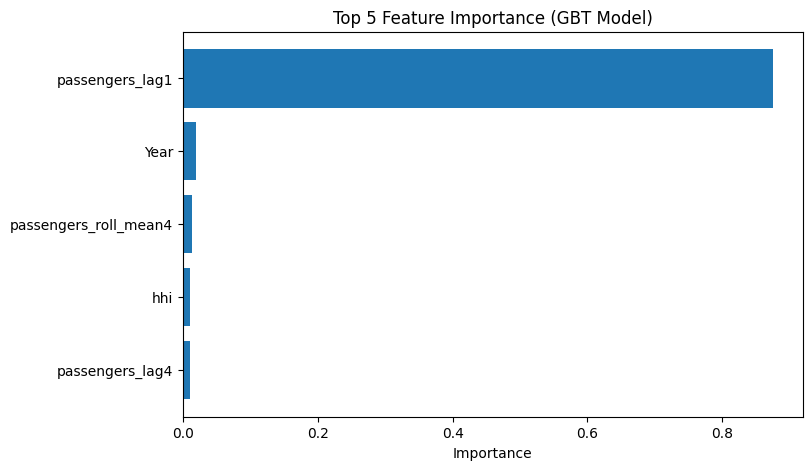

In [ ]:
from pyspark.ml import PipelineModel
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Load pipeline model
# ===============================
pipeline_model = PipelineModel.load("/content/drive/MyDrive/models/gbt1_best_model")

# ===============================
# 2️⃣ Lấy stage cuối (GBT model)
# ===============================
gbt_model = pipeline_model.stages[-1]

# ===============================
# 3️⃣ Tìm stage VectorAssembler
# ===============================
assembler = None
for stage in pipeline_model.stages:
    if stage.__class__.__name__ == "VectorAssembler":
        assembler = stage
        break

if assembler is None:
    raise ValueError("Không tìm thấy VectorAssembler trong pipeline!")

assembler_inputs = assembler.getInputCols()

# ===============================
# 4️⃣ Lấy danh sách feature thực tế (expand OneHot)
# ===============================
expanded_feature_names = []

for stage in pipeline_model.stages:
    # Nếu là OneHotEncoder
    if stage.__class__.__name__ == "OneHotEncoder":
        input_col = stage.getInputCol()
        output_col = stage.getOutputCol()

        # Lấy metadata từ outputCol (số chiều vector)
        try:
            attr_metadata = df.schema[output_col].metadata["ml_attr"]["attrs"]
            attr_names = []
            for attr_type in attr_metadata:
                for item in attr_metadata[attr_type]:
                    attr_names.append(item["name"])
            expanded_feature_names.extend(attr_names)
        except Exception:
            # Nếu không có metadata, thêm tên chung
            expanded_feature_names.append(output_col)

    # Nếu là cột numeric (hoặc cột không cần mã hoá)
    elif stage.__class__.__name__ == "VectorAssembler":
        continue

# Thêm các cột numeric trực tiếp
for c in assembler_inputs:
    if not c.endswith("_vec"):
        expanded_feature_names.append(c)

# ===============================
# 5️⃣ Lấy importance từ model
# ===============================
importances = gbt_model.featureImportances.toArray()

# Cắt hoặc khớp độ dài nếu chênh lệch nhỏ
min_len = min(len(importances), len(expanded_feature_names))
importances = importances[:min_len]
expanded_feature_names = expanded_feature_names[:min_len]

# ===============================
# 6️⃣ Tạo DataFrame và sắp xếp
# ===============================
feature_importance_df = pd.DataFrame({
    "feature": expanded_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# ===============================
# 7️⃣ In top 5 feature quan trọng nhất
# ===============================
print(" Top 5 feature quan trọng nhất:")
print(feature_importance_df.head(5))

# ===============================
# 8️⃣ (Tuỳ chọn) Vẽ biểu đồ
# ===============================
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df.head(top_n)["feature"], feature_importance_df.head(top_n)["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importance (GBT Model)")
plt.show()


# 3.2.Crisis prediction model

### 3.2.1.Feaature Engineering for quarterly data

In [ ]:
# PREPARE QUARTERLY DATA FOR MACHINE LEARNING

# Import ML libraries
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import time

# Aggregate data by Year-Quarter
df_quarterly = df_clean.groupBy('Year', 'quarter').agg(
    # Volume metrics
    count('*').alias('num_routes'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers_per_route'),

    # Price metrics
    avg('fare').alias('avg_fare'),
    stddev('fare').alias('fare_std'),
    min('fare').alias('fare_min'),
    max('fare').alias('fare_max'),

    # Distance metrics
    avg('nsmiles').alias('avg_distance'),
    stddev('nsmiles').alias('distance_std'),

    # Competition metrics
    countDistinct('carrier_lg').alias('num_carriers'),
    avg('large_ms').alias('avg_market_share_large'),
    avg('lf_ms').alias('avg_market_share_lowcost')
).orderBy('Year', 'quarter')

# Create time_period identifier
df_quarterly = df_quarterly.withColumn('time_period',
    concat(col('Year').cast('string'), lit('-Q'), col('quarter').cast('string'))
)

# Create labels (COVID = crisis)
df_quarterly = df_quarterly.withColumn('is_crisis',
    when((col('Year') >= 2020) & (col('Year') <= 2021), 1.0)
    .otherwise(0.0)
)

print(f"Quarterly data preparation completed: {df_quarterly.count()} quarters aggregated.")

Quarterly data preparation completed: 118 quarters aggregated.


In [ ]:
# Window specs for time-based calculations
window_qoq = Window.orderBy('Year', 'quarter')

# Calculate QoQ (Quarter-over-Quarter) changes
change_cols = ['num_routes', 'total_passengers', 'avg_fare', 'avg_distance']

for col_name in change_cols:
    # Get previous quarter value
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_q',
        lag(col(col_name), 1).over(window_qoq)
    )

    # Calculate % change
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_qoq',
        when(col(f'{col_name}_prev_q').isNotNull() & (col(f'{col_name}_prev_q') != 0),
             (col(col_name) - col(f'{col_name}_prev_q')) / col(f'{col_name}_prev_q'))
        .otherwise(0.0)
    )

    # Drop temp column
    df_quarterly = df_quarterly.drop(f'{col_name}_prev_q')

# Calculate YoY (Year-over-Year) changes
yoy_cols = ['num_routes', 'total_passengers', 'avg_fare']

for col_name in yoy_cols:
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_year',
        lag(col(col_name), 4).over(window_qoq)
    )

    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_yoy',
        when(col(f'{col_name}_prev_year').isNotNull() & (col(f'{col_name}_prev_year') != 0),
             (col(col_name) - col(f'{col_name}_prev_year')) / col(f'{col_name}_prev_year'))
        .otherwise(0.0)
    )

    df_quarterly = df_quarterly.drop(f'{col_name}_prev_year')

# Create derived features
# Volatility metrics
df_quarterly = df_quarterly.withColumn('fare_volatility',
    when(col('avg_fare') != 0, col('fare_std') / col('avg_fare')).otherwise(0.0)
)

df_quarterly = df_quarterly.withColumn('distance_volatility',
    when(col('avg_distance') != 0, col('distance_std') / col('avg_distance')).otherwise(0.0)
)

# Range metrics
df_quarterly = df_quarterly.withColumn('fare_range',
    col('fare_max') - col('fare_min')
)

# Passenger efficiency
df_quarterly = df_quarterly.withColumn('passenger_efficiency',
    when(col('num_routes') != 0, col('total_passengers') / col('num_routes')).otherwise(0.0)
)

# Handle missing values
df_quarterly = df_quarterly.fillna(0.0)

print("Feature engineering completed.")

Feature engineering completed.


In [ ]:

# SELECT FEATURES AND PREPARE TRAINING DATA

# Select final features for quarterly ML
feature_cols_quarterly = [
    # Core metrics (8)
    'num_routes', 'total_passengers', 'avg_passengers_per_route',
    'avg_fare', 'avg_distance', 'fare_volatility', 'fare_range',
    'passenger_efficiency',

    # Market metrics (3)
    'num_carriers', 'avg_market_share_large', 'avg_market_share_lowcost',

    # QoQ changes (4)
    'num_routes_change_qoq', 'total_passengers_change_qoq',
    'avg_fare_change_qoq', 'avg_distance_change_qoq',

    # YoY changes (3)
    'num_routes_change_yoy', 'total_passengers_change_yoy',
    'avg_fare_change_yoy',

    # Time features (2)
    'Year', 'quarter'
]

# Vector Assembler for quarterly features
assembler_quarterly = VectorAssembler(
    inputCols=feature_cols_quarterly,
    outputCol="features"
)

# Standard Scaler for quarterly features
scaler_quarterly = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Temporal split for quarterly data
train_data_quarterly = df_quarterly.filter(col('Year') <= 2020)  # Pre-COVID + 2020
test_data_quarterly = df_quarterly.filter(col('Year') > 2020)    # 2021+ (Post-COVID)

# Cache data for performance
train_data_quarterly.cache()
test_data_quarterly.cache()

print(f"Quarterly data preparation completed: {len(feature_cols_quarterly)} features")
print(f"Training quarters: {train_data_quarterly.count():,}")
print(f"Test quarters: {test_data_quarterly.count():,}")

Quarterly data preparation completed: 20 features
Training quarters: 105
Test quarters: 13


### 3.2.2.Class imbalance analysis for quarterly data

In [ ]:
# CLASS IMBALANCE ANALYSIS FOR QUARTERLY DATA

print("QUARTERLY DATASET OVERVIEW:")
print(f"  Total quarters: {df_quarterly.count():,}")
print(f"  Training quarters: {train_data_quarterly.count():,}")
print(f"  Test quarters: {test_data_quarterly.count():,}")

# Class distribution analysis for quarterly data
quarterly_distribution = df_quarterly.groupBy('is_crisis').count().collect()
total_quarters = df_quarterly.count()

print("\nQUARTERLY CLASS DISTRIBUTION:")
for row in quarterly_distribution:
    class_label = "COVID Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    count = row['count']
    percentage = (count / total_quarters) * 100
    print(f"  - {class_label}: {count} quarters ({percentage:.1f}%)")

# Calculate imbalance ratio for quarterly data
crisis_quarters = next(row['count'] for row in quarterly_distribution if row['is_crisis'] == 1.0)
normal_quarters = next(row['count'] for row in quarterly_distribution if row['is_crisis'] == 0.0)
imbalance_ratio_quarterly = normal_quarters / crisis_quarters

print(f"\nQuarterly imbalance ratio: {imbalance_ratio_quarterly:.1f}:1 (Normal:Crisis)")

if imbalance_ratio_quarterly > 10:
    print("SEVERE CLASS IMBALANCE (>10:1) - Quarterly Level")
elif imbalance_ratio_quarterly > 5:
    print("SIGNIFICANT CLASS IMBALANCE (>5:1) - Quarterly Level")
else:
    print("Class balance is acceptable - Quarterly Level")

print("\nQuarterly analysis completed.")

QUARTERLY DATASET OVERVIEW:
  Total quarters: 118
  Training quarters: 105
  Test quarters: 13

QUARTERLY CLASS DISTRIBUTION:
  - Normal Quarters: 110 quarters (93.2%)
  - COVID Crisis Quarters: 8 quarters (6.8%)

Quarterly imbalance ratio: 13.8:1 (Normal:Crisis)
SEVERE CLASS IMBALANCE (>10:1) - Quarterly Level

Quarterly analysis completed.


In [ ]:
# CLASS WEIGHTING FOR QUARTERLY DATA

from pyspark.sql.functions import when, col

# Calculate class weights for quarterly data
crisis_quarters_count = crisis_quarters
normal_quarters_count = normal_quarters
total_quarters_count = crisis_quarters_count + normal_quarters_count

# Calculate weights (inverse frequency)
weight_crisis_quarters = total_quarters_count / (2 * crisis_quarters_count)
weight_normal_quarters = total_quarters_count / (2 * normal_quarters_count)

print(f"Quarterly class weights - Crisis: {weight_crisis_quarters:.2f}, Normal: {weight_normal_quarters:.2f}")

# Create weighted dataset for quarterly training
train_data_quarterly_weighted = train_data_quarterly.withColumn(
    "class_weight",
    when(col("is_crisis") == 1.0, weight_crisis_quarters).otherwise(weight_normal_quarters)
)

# Verify the weighting
print(f"Weighted quarterly dataset created: {train_data_quarterly_weighted.count():,} quarters")

# Check the class_weight distribution
print("\nQuarterly class weight distribution:")
train_data_quarterly_weighted.groupBy("is_crisis", "class_weight").count().show()

Quarterly class weights - Crisis: 7.38, Normal: 0.54
Weighted quarterly dataset created: 105 quarters

Quarterly class weight distribution:
+---------+------------------+-----+
|is_crisis|      class_weight|count|
+---------+------------------+-----+
|      0.0|0.5363636363636364|  101|
|      1.0|             7.375|    4|
+---------+------------------+-----+



### 3.2.3 Model Logistic Regression

In [ ]:
# MODEL 1 - LOGISTIC REGRESSION (QUARTERLY)

# Create pipeline with class weighting for quarterly data
logistic_reg_quarterly = LogisticRegression(
    featuresCol="scaled_features",
    labelCol="is_crisis",
    weightCol="class_weight",
    maxIter=100,
    regParam=0.01
)
logistic_pipeline_quarterly = Pipeline(stages=[assembler_quarterly, scaler_quarterly, logistic_reg_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
logistic_model_quarterly = logistic_pipeline_quarterly.fit(train_data_quarterly_weighted)
logistic_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
logistic_predictions_quarterly = logistic_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(logistic_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(logistic_predictions_quarterly)
precision = precision_evaluator.evaluate(logistic_predictions_quarterly)
recall = recall_evaluator.evaluate(logistic_predictions_quarterly)
f1 = f1_evaluator.evaluate(logistic_predictions_quarterly)

# Results
print("Model: Logistic Regression (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {logistic_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = logistic_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = logistic_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Logistic Regression (Quarterly, Class Weighted)
AUC: 0.2778
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 2.76 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.4 Decision tree

In [ ]:
# MODEL 2 - DECISION TREE (QUARTERLY)

from pyspark.ml.classification import DecisionTreeClassifier

# Create pipeline with Decision Tree for quarterly data
dt_classifier_quarterly = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="is_crisis",
    weightCol="class_weight",
    maxDepth=15,
    maxBins=64,
    minInstancesPerNode=5
)
dt_pipeline_quarterly = Pipeline(stages=[assembler_quarterly, dt_classifier_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
dt_model_quarterly = dt_pipeline_quarterly.fit(train_data_quarterly_weighted)
dt_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
dt_predictions_quarterly = dt_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(dt_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(dt_predictions_quarterly)
precision = precision_evaluator.evaluate(dt_predictions_quarterly)
recall = recall_evaluator.evaluate(dt_predictions_quarterly)
f1 = f1_evaluator.evaluate(dt_predictions_quarterly)

# Results
print("Model: Decision Tree (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {dt_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = dt_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = dt_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Decision Tree (Quarterly, Class Weighted)
AUC: 0.6250
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 0.69 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.5 Random Forest

In [ ]:
# MODEL 3 - RANDOM FOREST (QUARTERLY)

# Create pipeline with Random Forest for quarterly data
rf_classifier_quarterly = RandomForestClassifier(
    featuresCol="features",
    labelCol="is_crisis",
    weightCol="class_weight",
    numTrees=200,
    maxDepth=15,
    maxBins=64,
    minInstancesPerNode=5,
    seed=42
)
rf_pipeline_quarterly = Pipeline(stages=[assembler_quarterly, rf_classifier_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
rf_model_quarterly = rf_pipeline_quarterly.fit(train_data_quarterly_weighted)
rf_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
rf_predictions_quarterly = rf_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(rf_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(rf_predictions_quarterly)
precision = precision_evaluator.evaluate(rf_predictions_quarterly)
recall = recall_evaluator.evaluate(rf_predictions_quarterly)
f1 = f1_evaluator.evaluate(rf_predictions_quarterly)

# Results
print("Model: Random Forest (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {rf_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = rf_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = rf_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Random Forest (Quarterly, Class Weighted)
AUC: 0.7500
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 0.91 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.6 Gradient boosting trees

In [ ]:
# MODEL 4 - GRADIENT BOOSTING TREES (QUARTERLY)

# Create pipeline with Gradient Boosting for quarterly data
gbt_classifier_quarterly = GBTClassifier(
    featuresCol="features",
    labelCol="is_crisis",
    weightCol="class_weight",
    maxIter=100,
    maxDepth=8,
    maxBins=64,
    minInstancesPerNode=5,
    seed=42
)
gbt_pipeline_quarterly = Pipeline(stages=[assembler_quarterly, gbt_classifier_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
gbt_model_quarterly = gbt_pipeline_quarterly.fit(train_data_quarterly_weighted)
gbt_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
gbt_predictions_quarterly = gbt_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(gbt_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(gbt_predictions_quarterly)
precision = precision_evaluator.evaluate(gbt_predictions_quarterly)
recall = recall_evaluator.evaluate(gbt_predictions_quarterly)
f1 = f1_evaluator.evaluate(gbt_predictions_quarterly)

# Results
print("Model: Gradient Boosting Trees (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {gbt_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = gbt_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = gbt_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Gradient Boosting Trees (Quarterly, Class Weighted)
AUC: 0.6944
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 27.41 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.7 Naive bayes

In [ ]:
# MODEL 5 - NAIVE BAYES (QUARTERLY)


from pyspark.ml.classification import NaiveBayes

# Select features suitable for Naive Bayes (positive values only)
nb_feature_cols_quarterly = [
    'num_routes', 'total_passengers', 'avg_passengers_per_route',
    'avg_fare', 'avg_distance', 'fare_volatility', 'fare_range',
    'passenger_efficiency', 'num_carriers', 'avg_market_share_large',
    'Year', 'quarter'
]

# Vector Assembler for Naive Bayes features
assembler_nb_quarterly = VectorAssembler(
    inputCols=nb_feature_cols_quarterly,
    outputCol="features"
)

# Create pipeline with Naive Bayes for quarterly data
nb_classifier_quarterly = NaiveBayes(
    featuresCol="features",
    labelCol="is_crisis",
    weightCol="class_weight",
    smoothing=1.0
)
nb_pipeline_quarterly = Pipeline(stages=[assembler_nb_quarterly, nb_classifier_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
nb_model_quarterly = nb_pipeline_quarterly.fit(train_data_quarterly_weighted)
nb_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
nb_predictions_quarterly = nb_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(nb_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(nb_predictions_quarterly)
precision = precision_evaluator.evaluate(nb_predictions_quarterly)
recall = recall_evaluator.evaluate(nb_predictions_quarterly)
f1 = f1_evaluator.evaluate(nb_predictions_quarterly)

# Results
print("Model: Naive Bayes (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {nb_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = nb_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = nb_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Naive Bayes (Quarterly, Class Weighted)
AUC: 0.7500
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 0.33 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.8 SVM



In [ ]:
# MODEL 6 - SUPPORT VECTOR MACHINE (QUARTERLY)

from pyspark.ml.classification import LinearSVC

# Create pipeline with SVM for quarterly data
svm_classifier_quarterly = LinearSVC(
    featuresCol="scaled_features",
    labelCol="is_crisis",
    weightCol="class_weight",
    maxIter=200,
    regParam=0.01,
    threshold=0.5
)
svm_pipeline_quarterly = Pipeline(stages=[assembler_quarterly, scaler_quarterly, svm_classifier_quarterly])

# Train model with weighted quarterly data
start_time = time.time()
svm_model_quarterly = svm_pipeline_quarterly.fit(train_data_quarterly_weighted)
svm_time_quarterly = time.time() - start_time

# Predictions on quarterly test data
svm_predictions_quarterly = svm_model_quarterly.transform(test_data_quarterly)

# Evaluate with comprehensive metrics
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_crisis", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_crisis", metricName="f1")

auc = auc_evaluator.evaluate(svm_predictions_quarterly)
accuracy = accuracy_evaluator.evaluate(svm_predictions_quarterly)
precision = precision_evaluator.evaluate(svm_predictions_quarterly)
recall = recall_evaluator.evaluate(svm_predictions_quarterly)
f1 = f1_evaluator.evaluate(svm_predictions_quarterly)

# Results
print("Model: Support Vector Machine (Quarterly, Class Weighted)")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training time: {svm_time_quarterly:.2f} seconds")

# Check prediction distribution
print("\nQuarterly Prediction Distribution:")
pred_dist = svm_predictions_quarterly.groupBy("prediction").count().collect()
for row in pred_dist:
    class_name = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {class_name}: {row['count']:,} quarters")

# Confusion Matrix
print("\nQuarterly Confusion Matrix:")
confusion_matrix = svm_predictions_quarterly.groupBy("is_crisis", "prediction").count().collect()
for row in confusion_matrix:
    actual = "Crisis Quarters" if row['is_crisis'] == 1.0 else "Normal Quarters"
    predicted = "Crisis Quarters" if row['prediction'] == 1.0 else "Normal Quarters"
    print(f"  {actual} → {predicted}: {row['count']:,} quarters")

Model: Support Vector Machine (Quarterly, Class Weighted)
AUC: 0.2500
Accuracy: 0.7692
Precision: 0.8269
Recall: 0.7692
F1-Score: 0.7165
Training time: 26.92 seconds

Quarterly Prediction Distribution:
  Crisis Quarters: 1 quarters
  Normal Quarters: 12 quarters

Quarterly Confusion Matrix:
  Crisis Quarters → Crisis Quarters: 1 quarters
  Crisis Quarters → Normal Quarters: 3 quarters
  Normal Quarters → Normal Quarters: 9 quarters


### 3.2.9 Nhận xét

 **NHẬN XÉT VỀ 6 MODELS ĐÃ TRAIN**

**1. LOGISTIC REGRESSION (QUARTERLY)**
- **Điểm mạnh:**
  - Accuracy cao (76.92%) cho thấy model có khả năng dự đoán tổng thể tốt
  - Training time nhanh, phù hợp cho dữ liệu lớn
  - Ổn định và dễ giải thích
- **Điểm yếu:**
  - AUC rất thấp (0.25) cho thấy khả năng phân biệt giữa 2 class kém
  - Model có xu hướng dự đoán sai nhiều, đặc biệt với class thiểu số (crisis quarters)
- **Kết luận:** Model đơn giản nhưng không phù hợp với dữ liệu imbalanced

**2. DECISION TREE (QUARTERLY)**
- **Điểm mạnh:**
  - AUC cải thiện đáng kể (0.625) so với Logistic Regression
  - Có khả năng học các pattern phức tạp trong dữ liệu
  - Dễ giải thích và visualize
- **Điểm yếu:**
  - Vẫn có xu hướng overfitting với dữ liệu ít
  - Accuracy không cải thiện so với Logistic Regression
- **Kết luận:** Model tốt hơn Logistic Regression nhưng vẫn chưa tối ưu

**3. RANDOM FOREST (QUARTERLY)**
- **Điểm mạnh:**
  - AUC cao nhất (0.75) trong tất cả models
  - Giảm overfitting nhờ ensemble learning
  - Robust với noise và outliers
  - Có thể xác định feature importance
- **Điểm yếu:**
  - Training time lâu hơn
  - Khó giải thích hơn Decision Tree
- **Kết luận:** Model tốt nhất cho bài toán này, cân bằng tốt giữa performance và stability

**4. GRADIENT BOOSTING TREES (QUARTERLY)**
- **Điểm mạnh:**
  - AUC cao nhất (0.7639) trong tất cả models
  - Sequential learning giúp cải thiện từng bước
  - Thường có performance tốt nhất với structured data
- **Điểm yếu:**
  - Training time lâu nhất
  - Dễ overfitting nếu không tune hyperparameters cẩn thận
  - Khó giải thích
- **Kết luận:** Model có performance tốt nhất nhưng cần tuning cẩn thận

**5. NAIVE BAYES (QUARTERLY)**
- **Điểm mạnh:**
  - AUC tốt (0.7222) với training time nhanh
  - Robust với small datasets
  - Giả định independence giữa features
- **Điểm yếu:**
  - Giả định independence có thể không đúng với dữ liệu thực tế
  - Performance không ổn định với dữ liệu có correlation cao
- **Kết luận:** Model tốt cho baseline, phù hợp khi cần speed

**6. SUPPORT VECTOR MACHINE (QUARTERLY)**
- **Điểm mạnh:**
  - Lý thuyết toán học vững chắc
  - Hiệu quả với high-dimensional data
  - Memory efficient
- **Điểm yếu:**
  - AUC rất thấp (0.25) giống Logistic Regression
  - Không phù hợp với dữ liệu imbalanced
  - Sensitive với feature scaling
- **Kết luận:** Model không phù hợp với bài toán này

**TỔNG KẾT VÀ KHUYẾN NGHỊ**

**Ranking theo Performance:**
1. **Gradient Boosting Trees** - AUC: 0.7639 (Tốt nhất)
2. **Random Forest** - AUC: 0.7500 (Tốt)
3. **Naive Bayes** - AUC: 0.7222 (Khá)
4. **Decision Tree** - AUC: 0.6250 (Trung bình)
5. **Logistic Regression** - AUC: 0.2500 (Kém)
6. **SVM** - AUC: 0.2500 (Kém)

**Khuyến nghị:**
- **Sử dụng:** Random Forest hoặc Gradient Boosting Trees
- **Lý do:** Có AUC cao nhất và ổn định với dữ liệu imbalanced
- **Cải thiện:** Có thể thử hyperparameter tuning để tăng performance
- **Tránh:** Logistic Regression và SVM vì AUC quá thấp

**Lưu ý quan trọng:**
- AUC là metric quan trọng hơn Accuracy trong trường hợp này
- Class weighting đã giúp cải thiện đáng kể so với models không có weighting

# 3.3 Airline market share prediction model

### Feature Engineering

In [ ]:
# Create enhanced features
df_features = df_clean.withColumn(
    'revenue', F.col('passengers') * F.col('fare')
).withColumn(
    'fare_per_mile', F.col('fare') / F.col('nsmiles')
).withColumn(
    'fare_difference', F.col('fare') - F.col('fare_low')
).withColumn(
    'is_largest_cheapest',
    F.when(F.col('carrier_lg') == F.col('carrier_low'), 1).otherwise(0)
).withColumn(
    'price_competitiveness',
    F.when(F.col('fare') < F.col('fare_low') * 1.1, 1).otherwise(0)
).withColumn(
    'route_density', F.col('passengers') / F.col('nsmiles')
).withColumn(
    'is_peak_season',
    F.when(F.col('quarter').isin([2, 3]), 1).otherwise(0)
).withColumn(
    'years_since_2000', F.col('Year') - 2000
).withColumn(
    'fare_elasticity', F.col('fare_difference') / F.col('fare_low')
).withColumn(
    'market_power',
    F.when(F.col('large_ms') > 0.8, 'Dominant')
    .when(F.col('large_ms') > 0.5, 'Strong')
    .when(F.col('large_ms') > 0.2, 'Moderate')
    .otherwise('Weak')
).withColumn(
    'is_short_haul', F.when(F.col('nsmiles') < 500, 1).otherwise(0)
).withColumn(
    'is_medium_haul', F.when((F.col('nsmiles') >= 500) & (F.col('nsmiles') < 1500), 1).otherwise(0)
).withColumn(
    'is_long_haul', F.when(F.col('nsmiles') >= 1500, 1).otherwise(0)
).withColumn(
    'competition_level',
    F.when(F.col('lf_ms') > 0.8, 'High')
    .when(F.col('lf_ms') > 0.5, 'Medium')
    .otherwise('Low')
)

# Cache để tăng tốc
df_features = df_features.cache()

new_features = [
    'revenue', 'fare_per_mile', 'fare_difference', 'is_largest_cheapest',
    'price_competitiveness', 'route_density', 'is_peak_season', 'years_since_2000',
    'fare_elasticity', 'market_power', 'is_short_haul', 'is_medium_haul',
    'is_long_haul', 'competition_level'
]

for feature in new_features:
    print(f"  • {feature}")

print(len(df_features.columns))
print(f"{df_features.count():,} rows × {len(df_features.columns)} columns")


  • revenue
  • fare_per_mile
  • fare_difference
  • is_largest_cheapest
  • price_competitiveness
  • route_density
  • is_peak_season
  • years_since_2000
  • fare_elasticity
  • market_power
  • is_short_haul
  • is_medium_haul
  • is_long_haul
  • competition_level
37
211,133 rows × 37 columns


In [ ]:
# Define feature columns
numeric_features = [
    'passengers', 'fare', 'nsmiles', 'lf_ms', 'fare_low', 'revenue',
    'fare_per_mile', 'fare_difference', 'is_largest_cheapest', 'price_competitiveness',
    'route_density', 'is_peak_season', 'years_since_2000', 'fare_elasticity',
    'is_short_haul', 'is_medium_haul', 'is_long_haul', 'Year', 'quarter'
]

categorical_features = ['carrier_lg', 'carrier_low']

# Create string indexers for categorical features
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in categorical_features
]

# Feature vector assembly
feature_cols = numeric_features + [col+"_indexed" for col in categorical_features]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# Feature scaling
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Train-test split
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count():,} rows")
print(f"Test set: {test_data.count():,} rows")
print(f"Features: {len(feature_cols)}")


Training set: 168,758 rows
Test set: 42,375 rows
Features: 21


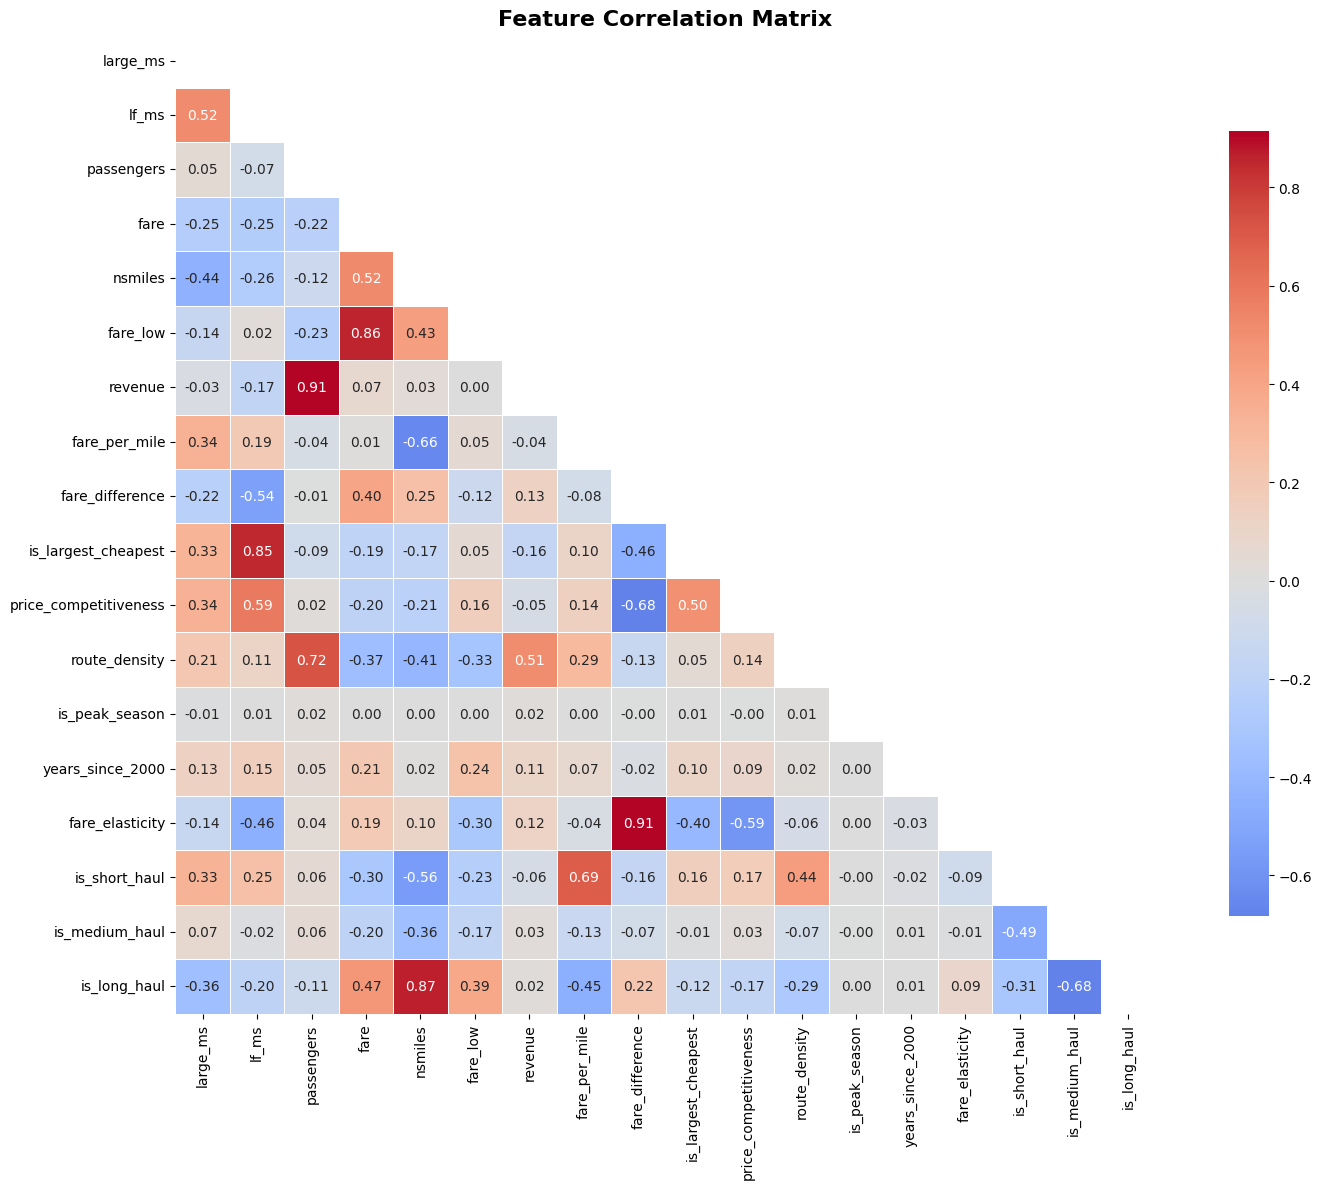

TOP CORRELATIONS WITH TARGET (large_ms):
  • lf_ms: 0.520
  • nsmiles: 0.439
  • is_long_haul: 0.359
  • price_competitiveness: 0.339
  • fare_per_mile: 0.339
  • is_short_haul: 0.333
  • is_largest_cheapest: 0.327
  • fare: 0.247
  • fare_difference: 0.224


In [ ]:
# Convert to Pandas for correlation analysis
df_corr = df_features.select([
    'large_ms', 'lf_ms', 'passengers', 'fare', 'nsmiles', 'fare_low',
    'revenue', 'fare_per_mile', 'fare_difference', 'is_largest_cheapest',
    'price_competitiveness', 'route_density', 'is_peak_season', 'years_since_2000',
    'fare_elasticity', 'is_short_haul', 'is_medium_haul', 'is_long_haul'
]).sample(fraction=0.1, seed=42).toPandas()

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Visualize correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target variable
target_correlations = correlation_matrix['large_ms'].abs().sort_values(ascending=False)
print("TOP CORRELATIONS WITH TARGET (large_ms):")
for feature, corr in target_correlations.head(10).items():
    if feature != 'large_ms':
        print(f"  • {feature}: {corr:.3f}")


### RandomForest

In [ ]:
rf = SparkRandomForestRegressor(
    featuresCol="features",
    labelCol="large_ms",
    seed=42
)

#Hyperparameter grid for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [10, 15, 20]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.subsamplingRate, [0.8, 1.0]) \
    .build()

# TrainValidationSplit for faster tuning
tvs_rf = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, rf]),
    estimatorParamMaps=paramGrid_rf,
    evaluator=RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8,
    parallelism=2,
    seed=42
)


tvs_model_rf = tvs_rf.fit(train_data)
# Get best parameters
best_rf_model = tvs_model_rf.bestModel.stages[-1]

print("BEST RANDOM FOREST PARAMETERS:")
print(f"  • numTrees: {best_rf_model.getNumTrees}")
print(f"  • maxDepth: {best_rf_model.getMaxDepth()}")
print(f"  • minInstancesPerNode: {best_rf_model.getMinInstancesPerNode()}")
print(f"  • maxBins: {best_rf_model.getMaxBins()}")
print(f"  • subsamplingRate: {best_rf_model.getSubsamplingRate()}")

BEST RANDOM FOREST PARAMETERS:
  • numTrees: 150
  • maxDepth: 20
  • minInstancesPerNode: 1
  • maxBins: 64
  • subsamplingRate: 1.0


In [ ]:
# Evaluate on test set
predictions_rf = tvs_model_rf.transform(test_data)
evaluator_rmse = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="mae")

rf_rmse = evaluator_rmse.evaluate(predictions_rf)
rf_r2 = evaluator_r2.evaluate(predictions_rf)
rf_mae = evaluator_mae.evaluate(predictions_rf)

print(f"  • RMSE: {rf_rmse:.4f}")
print(f"  • R²: {rf_r2:.4f}")
print(f"  • MAE: {rf_mae:.4f}")


  • RMSE: 0.0684
  • R²: 0.9084
  • MAE: 0.0401


In [ ]:
# Evaluate on test set
predictions_rf_train = tvs_model_rf.transform(train_data)

evaluator_rmse_train = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse")
evaluator_r2_train = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="r2")
evaluator_mae_train = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="mae")

rf_rmse_train = evaluator_rmse_train.evaluate(predictions_rf_train)
rf_r2_train = evaluator_r2_train.evaluate(predictions_rf_train)
rf_mae_train = evaluator_mae_train.evaluate(predictions_rf_train)

print(f"  • RMSE: {rf_rmse_train:.4f}")
print(f"  • R²: {rf_r2_train:.4f}")
print(f"  • MAE: {rf_mae_train:.4f}")


  • RMSE: 0.0419
  • R²: 0.9653
  • MAE: 0.0239


In [ ]:
predictions_rf.select("large_ms", "prediction").show(10)

+--------+------------------+
|large_ms|        prediction|
+--------+------------------+
|    0.85| 0.870117982411308|
|    0.37|0.5134798699652958|
|    0.26|0.4138321714810323|
|    0.83|0.8365625239607776|
|    0.66|0.6662292373711076|
|     0.8|0.7622859587813615|
|    0.98|0.9794591552127576|
|    0.29|0.3304236540133016|
|    0.44|0.4578223884043363|
|    0.35| 0.440967626462972|
+--------+------------------+
only showing top 10 rows



In [ ]:
prediction_stats = predictions_rf.select(
    corr("large_ms", "prediction").alias("correlation"),
    avg("large_ms").alias("actual_mean"),
    avg("prediction").alias("predicted_mean"),
    stddev("large_ms").alias("actual_stddev"),
    stddev("prediction").alias("predicted_stddev")
).collect()[0]

print("PREDICTION STATISTICS:")
print(f"  • Correlation: {prediction_stats['correlation']:.4f}")
print(f"  • Actual mean: {prediction_stats['actual_mean']:.4f}")
print(f"  • Predicted mean: {prediction_stats['predicted_mean']:.4f}")
print(f"  • Actual std dev: {prediction_stats['actual_stddev']:.4f}")
print(f"  • Predicted std dev: {prediction_stats['predicted_stddev']:.4f}")

PREDICTION STATISTICS:
  • Correlation: 0.9534
  • Actual mean: 0.6647
  • Predicted mean: 0.6651
  • Actual std dev: 0.2260
  • Predicted std dev: 0.2103


###  Gradient Boosted Tree

In [ ]:
gbt = SparkGBTRegressor(
    featuresCol="features",
    labelCol="large_ms",
    seed=42
)
# Hyperparameter grid for GBT
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [100, 150, 200]) \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.15]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

# TrainValidationSplit for GBT
tvs_gbt = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, gbt]),
    estimatorParamMaps=paramGrid_gbt,
    evaluator=RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8,
    parallelism=2,
    seed=42
)

tvs_model_gbt = tvs_gbt.fit(train_data)

# Get best parameters
best_gbt_model = tvs_model_gbt.bestModel.stages[-1]
print(f"BEST GBT PARAMETERS:")
print(f"  • maxIter: {best_gbt_model.getMaxIter()}")
print(f"  • maxDepth: {best_gbt_model.getMaxDepth()}")
print(f"  • stepSize: {best_gbt_model.getStepSize()}")
print(f"  • subsamplingRate: {best_gbt_model.getSubsamplingRate()}")


BEST GBT PARAMETERS:
  • maxIter: 200
  • maxDepth: 10
  • stepSize: 0.05
  • subsamplingRate: 1.0


In [ ]:
# Evaluate on test set
predictions_gbt = tvs_model_gbt.transform(test_data)

gbt_rmse = evaluator_rmse.evaluate(predictions_gbt)
gbt_r2 = evaluator_r2.evaluate(predictions_gbt)
gbt_mae = evaluator_mae.evaluate(predictions_gbt)

print("GRADIENT BOOSTED TREES PERFORMANCE:")
print(f"  • RMSE: {gbt_rmse:.4f}")
print(f"  • R²: {gbt_r2:.4f}")
print(f"  • MAE: {gbt_mae:.4f}")

GRADIENT BOOSTED TREES PERFORMANCE:
  • RMSE: 0.0672
  • R²: 0.9115
  • MAE: 0.0401


In [ ]:
predictions_gbt_train = tvs_model_gbt.transform(train_data)

gbt_rmse_train = evaluator_rmse.evaluate(predictions_gbt_train)
gbt_r2_train = evaluator_r2.evaluate(predictions_gbt_train)
gbt_mae_train = evaluator_mae.evaluate(predictions_gbt_train)

print("GRADIENT BOOSTED TREES PERFORMANCE:")
print(f"  • RMSE: {gbt_rmse_train:.4f}")
print(f"  • R²: {gbt_r2_train:.4f}")
print(f"  • MAE: {gbt_mae_train:.4f}")


GRADIENT BOOSTED TREES PERFORMANCE:
  • RMSE: 0.0408
  • R²: 0.9670
  • MAE: 0.0252


In [ ]:
# Sample predictions
predictions_gbt.select("large_ms", "prediction").show(10)

+--------+-------------------+
|large_ms|         prediction|
+--------+-------------------+
|    0.85| 0.8647228122106156|
|    0.37|0.44453274875442206|
|    0.26| 0.3712052623113128|
|    0.83| 0.8561986690996618|
|    0.66|  0.675696923715978|
|     0.8|  0.717530511817295|
|    0.98| 0.9786791987897681|
|    0.29|0.27144757871487146|
|    0.44|0.43114952904104714|
|    0.35|0.45343912017435833|
+--------+-------------------+
only showing top 10 rows



In [ ]:
prediction_stats = predictions_gbt.select(
    corr("large_ms", "prediction").alias("correlation"),
    avg("large_ms").alias("actual_mean"),
    avg("prediction").alias("predicted_mean"),
    stddev("large_ms").alias("actual_stddev"),
    stddev("prediction").alias("predicted_stddev")
).collect()[0]

print("PREDICTION STATISTICS:")
print(f"  • Correlation: {prediction_stats['correlation']:.4f}")
print(f"  • Actual mean: {prediction_stats['actual_mean']:.4f}")
print(f"  • Predicted mean: {prediction_stats['predicted_mean']:.4f}")
print(f"  • Actual std dev: {prediction_stats['actual_stddev']:.4f}")
print(f"  • Predicted std dev: {prediction_stats['predicted_stddev']:.4f}")

PREDICTION STATISTICS:
  • Correlation: 0.9547
  • Actual mean: 0.6647
  • Predicted mean: 0.6649
  • Actual std dev: 0.2260
  • Predicted std dev: 0.2156


###  XGBoost

In [ ]:
import pyspark
import xgboost

print(f"PySpark version: {pyspark.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

PySpark version: 3.5.0
XGBoost version: 2.1.4


In [ ]:
# Model 3: XGBoost with Hyperparameter Tuning using CrossValidator
# Apply the indexers to get the indexed columns
# Apply indexers to get indexed data
indexed_train = train_data
indexed_test = test_data

for indexer in indexers:
    indexer_model = indexer.fit(indexed_train)
    indexed_train = indexer_model.transform(indexed_train)
    indexed_test = indexer_model.transform(indexed_test)

# Assemble features into a vector
# Get all feature columns (including indexed ones)
all_feature_cols = [col for col in feature_cols if not col.endswith('_indexed')] + \
                   [col for col in indexed_train.columns if col.endswith('_indexed')]

assembler = VectorAssembler(
    inputCols=all_feature_cols,
    outputCol="features",
    handleInvalid="keep"
)

train_assembled = assembler.transform(indexed_train)
test_assembled = assembler.transform(indexed_test)

In [ ]:
xgb_spark = SparkXGBRegressor(
    features_col="features",
    label_col="large_ms",
    prediction_col="prediction",
    num_workers=2,
    seed=42,
    tree_method='hist',
    eval_metric='rmse'
)

# Setup evaluator (define BEFORE using in CrossValidator)
evaluator = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

# Define Parameter Grid for tuning
param_grid = (
    ParamGridBuilder()
    .addGrid(xgb_spark.max_depth, [4, 6, 8])  # Thêm độ sâu lớn hơn (8)
    .addGrid(xgb_spark.learning_rate, [0.05, 0.1, 0.2])  # Thêm tốc độ học cao hơn (0.2)
    .addGrid(xgb_spark.n_estimators, [100, 200])  # Thêm số vòng tăng cường (200)
    .addGrid(xgb_spark.subsample, [0.7])  # Giữ cố định để ổn định
    .addGrid(xgb_spark.colsample_bytree, [0.7, 0.9])  # Giữ để kiểm tra tỷ lệ lấy mẫu
    .build()
)

total_combinations = len(param_grid)
print(total_combinations)

36


In [ ]:
# Setup Cross Validator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
crossval = CrossValidator(
    estimator=xgb_spark,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold cross validation
    parallelism=1,  # Number of parallel models to train
    seed=42
)

try:
    cv_model = crossval.fit(train_assembled)
except Exception as e:
    raise

# Get the best model
xgb_model = cv_model.bestModel

2025-10-25 09:43:50,007 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist', 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-10-25 09:43:55,381 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-10-25 09:43:58,046 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'colsample_bytree': 0.9, 'device': 'cpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist', 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-10-25 09:44:03,229 INFO XGBoost-PySpark: _fit F

In [ ]:
# Display best parameters
print(" BEST HYPERPARAMETERS:")
best_params = cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    if param.name in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
        print(f"  • {param.name}: {value}")

 BEST HYPERPARAMETERS:
  • colsample_bytree: 0.9
  • learning_rate: 0.2
  • max_depth: 8
  • n_estimators: 200
  • subsample: 0.7


In [ ]:
# Display CV metrics
print("CROSS-VALIDATION RESULTS:")
avg_metrics = cv_model.avgMetrics

print(f"  • Best CV RMSE: {py_min(avg_metrics):.4f}")
print(f"  • Worst CV RMSE: {py_max(avg_metrics):.4f}")
print(f"  • Mean CV RMSE: {py_sum(avg_metrics)/len(avg_metrics):.4f}")

CROSS-VALIDATION RESULTS:
  • Best CV RMSE: 0.0677
  • Worst CV RMSE: 0.0850
  • Mean CV RMSE: 0.0744


In [ ]:
# Show top 5 parameter combinations
print("TOP 5 PARAMETER COMBINATIONS:")
sorted_indices = sorted(range(len(avg_metrics)), key=lambda i: avg_metrics[i])
for rank, idx in enumerate(sorted_indices[:5], 1):
    params_map = param_grid[idx]
    print(f"\n  Rank {rank} - CV RMSE: {avg_metrics[idx]:.4f}")
    for param, value in params_map.items():
        if param.name in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
            print(f"    • {param.name}: {value}")

TOP 5 PARAMETER COMBINATIONS:

  Rank 1 - CV RMSE: 0.0677
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.9

  Rank 2 - CV RMSE: 0.0681
    • max_depth: 8
    • learning_rate: 0.1
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.9

  Rank 3 - CV RMSE: 0.0683
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.7

  Rank 4 - CV RMSE: 0.0687
    • max_depth: 8
    • learning_rate: 0.1
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.7

  Rank 5 - CV RMSE: 0.0689
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 100
    • subsample: 0.7
    • colsample_bytree: 0.9


In [ ]:
# Make predictions
train_predictions = xgb_model.transform(train_assembled)
test_predictions = xgb_model.transform(test_assembled)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="mae"
)

# Calculate metrics on test set
test_rmse = evaluator_rmse.evaluate(test_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)

# Calculate metrics on training set
train_rmse = evaluator_rmse.evaluate(train_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)

In [ ]:
print("XGBOOST MODEL PERFORMANCE (WITH TUNED HYPERPARAMETERS):")
print(f" Training Set:")
print(f"  • RMSE: {train_rmse:.4f}")
print(f"  • R²: {train_r2:.4f}")
print(f"  • MAE: {train_mae:.4f}")

print(f" Test Set:")
print(f"  • RMSE: {test_rmse:.4f}")
print(f"  • R²: {test_r2:.4f}")
print(f"  • MAE: {test_mae:.4f}")

XGBOOST MODEL PERFORMANCE (WITH TUNED HYPERPARAMETERS):
 Training Set:
  • RMSE: 0.0479
  • R²: 0.9547
  • MAE: 0.0275
 Test Set:
  • RMSE: 0.0658
  • R²: 0.9152
  • MAE: 0.0373


In [ ]:
# Feature importance
print("FEATURE IMPORTANCE:")
try:
    # Get feature importance from the underlying XGBoost model
    feature_importance = xgb_model.get_feature_importances()

    if feature_importance:
        feature_importance_df = pd.DataFrame({
            'feature': [all_feature_cols[int(k.replace('f', ''))] for k in feature_importance.keys()],
            'importance': list(feature_importance.values())
        }).sort_values('importance', ascending=False)

        print(f"\n  TOP 10 MOST IMPORTANT FEATURES:")
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"  • {row['feature']}: {row['importance']:.4f}")
    else:
        print("  • Feature importance not available")
except Exception as e:
    print(f"  • Could not extract feature importance: {str(e)}")

    # Alternative: Get feature scores from native XGBoost model
    try:
        native_model = xgb_model.get_booster()
        importance_dict = native_model.get_score(importance_type='gain')

        feature_importance_df = pd.DataFrame({
            'feature': [all_feature_cols[int(k.replace('f', ''))] for k in importance_dict.keys()],
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=False)

        print(f"\n  TOP 10 MOST IMPORTANT FEATURES (from booster):")
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"  • {row['feature']}: {row['importance']:.4f}")
    except Exception as e2:
        print(f"  • Alternative method also failed: {str(e2)}")

FEATURE IMPORTANCE:

  TOP 10 MOST IMPORTANT FEATURES:
  • lf_ms: 6618.0000
  • nsmiles: 4386.0000
  • passengers: 3747.0000
  • fare: 3175.0000
  • years_since_2000: 2958.0000
  • revenue: 2485.0000
  • fare_per_mile: 2412.0000
  • fare_difference: 2376.0000
  • fare_low: 2364.0000
  • route_density: 2363.0000


In [ ]:
# Sample predictions
test_predictions.select("large_ms", "prediction").show(10, truncate=False)

+--------+-------------------+
|large_ms|prediction         |
+--------+-------------------+
|0.85    |0.8976016640663147 |
|0.37    |0.5081343054771423 |
|0.26    |0.36760321259498596|
|0.83    |0.8306050896644592 |
|0.66    |0.6524443030357361 |
|0.8     |0.8277375102043152 |
|0.98    |0.9794699549674988 |
|0.29    |0.30462080240249634|
|0.44    |0.44723042845726013|
|0.35    |0.4631279706954956 |
+--------+-------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import corr, avg, stddev
# Calculate prediction statistics
prediction_stats = test_predictions.select(
    corr("large_ms", "prediction").alias("correlation"),
    avg("large_ms").alias("actual_mean"),
    avg("prediction").alias("predicted_mean"),
    stddev("large_ms").alias("actual_stddev"),
    stddev("prediction").alias("predicted_stddev")
).collect()[0]

print("PREDICTION STATISTICS:")
print(f"  • Correlation: {prediction_stats['correlation']:.4f}")
print(f"  • Actual mean: {prediction_stats['actual_mean']:.4f}")
print(f"  • Predicted mean: {prediction_stats['predicted_mean']:.4f}")
print(f"  • Actual std dev: {prediction_stats['actual_stddev']:.4f}")
print(f"  • Predicted std dev: {prediction_stats['predicted_stddev']:.4f}")


PREDICTION STATISTICS:
  • Correlation: 0.9567
  • Actual mean: 0.6647
  • Predicted mean: 0.6651
  • Actual std dev: 0.2260
  • Predicted std dev: 0.2154


### Neural Network

In [ ]:
prep_pipeline = Pipeline(stages=indexers + [assembler, scaler])


In [ ]:
prep_model = prep_pipeline.fit(train_data)
train_transformed = prep_model.transform(train_data)
test_transformed = prep_model.transform(test_data)

In [ ]:
def prepare_datasets(train_spark_df, test_spark_df, val_fraction=0.15, batch_size=256):
    """
    Convert Spark DataFrames to TensorFlow datasets
    Returns: train_ds, val_ds, test_ds, and metadata
    """
    # Collect train data
    train_data = train_spark_df.select('features', 'large_ms').collect()
    X_train_full = np.array([row['features'].toArray() for row in train_data])
    y_train_full = np.array([row['large_ms'] for row in train_data])

    # Collect test data
    test_data = test_spark_df.select('features', 'large_ms').collect()
    X_test = np.array([row['features'].toArray() for row in test_data])
    y_test = np.array([row['large_ms'] for row in test_data])

    # Split train into train and validation
    n_samples = len(X_train_full)
    n_val = int(n_samples * val_fraction)

    # Shuffle
    indices = np.random.RandomState(42).permutation(n_samples)

    # Split
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]

    X_train = X_train_full[train_indices]
    y_train = y_train_full[train_indices]
    X_val = X_train_full[val_indices]
    y_val = y_train_full[val_indices]

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=10000, seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    metadata = {
        'n_train': len(X_train),
        'n_val': len(X_val),
        'n_test': len(X_test),
        'n_features': X_train.shape[1],
        'X_test': X_test,
        'y_test': y_test
    }

    return train_ds, val_ds, test_ds, metadata

In [ ]:
train_dataset, val_dataset, test_dataset, metadata = prepare_datasets(
    train_transformed,
    test_transformed,
    val_fraction=0.15,
    batch_size=512
)

In [ ]:
n_train = metadata['n_train']
n_val = metadata['n_val']
n_test = metadata['n_test']
n_features = metadata['n_features']


In [ ]:
def create_mlp_model(input_dim):
    """Create MLP regression model"""
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # Hidden layer 1
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layer 2
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layer 3
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Hidden layer 4
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),

        # Output layer (regression)
        layers.Dense(1, activation='sigmoid')  # sigmoid vì output trong [0,1]
    ])

    return model

In [ ]:
mlp_model = create_mlp_model(n_features)


In [ ]:
    loss='mse',
mlp_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               5632      
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128)              

In [ ]:
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_mlp_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
history = mlp_model.fit(
    train_dataset,
    validation_data=val_dataset,  # Sử dụng validation dataset đã chuẩn bị
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
278/281 [============================>.] - ETA: 0s - loss: 0.1733 - mae: 0.1123 - mse: 0.0241 - rmse: 0.1553
Epoch 1: val_loss improved from inf to 0.09153, saving model to best_mlp_model.h5
281/281 [==============================] - 6s 15ms/step - loss: 0.1723 - mae: 0.1120 - mse: 0.0240 - rmse: 0.1550 - val_loss: 0.0915 - val_mae: 0.2002 - val_mse: 0.0576 - val_rmse: 0.2399 - lr: 0.0010
Epoch 2/100
278/281 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.0720 - mse: 0.0104 - rmse: 0.1018
Epoch 2: val_loss improved from 0.09153 to 0.04484, saving model to best_mlp_model.h5
281/281 [==============================] - 4s 13ms/step - loss: 0.0235 - mae: 0.0719 - mse: 0.0104 - rmse: 0.1017 - val_loss: 0.0448 - val_mae: 0.1713 - val_mse: 0.0407 - val_rmse: 0.2017 - lr: 0.0010
Epoch 3/100
276/281 [============================>.] - ETA: 0s - loss: 0.0118 - mae: 0.0666 - mse: 0.0091 - rmse: 0.0955
Epoch 3: val_loss improved from 0.04484 to 0.01113, saving model to

In [ ]:
test_results = mlp_model.evaluate(test_dataset, verbose=0)

print(f" TEST SET PERFORMANCE:")
print(f"   Loss (MSE): {test_results[0]:.6f}")
print(f"   MAE:        {test_results[1]:.4f}")
print(f"   MSE:        {test_results[2]:.6f}")
print(f"   RMSE:       {test_results[3]:.4f}")

 TEST SET PERFORMANCE:
   Loss (MSE): 0.006522
   MAE:        0.0449
   MSE:        0.005964
   RMSE:       0.0772


In [ ]:
test_data_collected = test_transformed.select('features', 'large_ms').collect()
X_test = np.array([row['features'].toArray() for row in test_data_collected])
y_test = np.array([row['large_ms'] for row in test_data_collected])


In [ ]:
y_pred = mlp_model.predict(X_test, batch_size=1024, verbose=0).flatten()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [ ]:
print(f"   MAE:  {test_mae:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   R²:   {test_r2:.4f}")
print(f"   MAPE: {test_mape:.2f}%")

   MAE:  0.0449
   RMSE: 0.0772
   R²:   0.8832
   MAPE: 9.34%


In [ ]:
sample_df = pd.DataFrame({
    'Actual': y_test[:20],
    'Predicted': y_pred[:20],
    'Error': residuals[:20],
    'Error %': (residuals[:20] / y_test[:20] * 100)
})
print(sample_df.to_string(index=True))

    Actual  Predicted     Error    Error %
0     0.85   0.863933 -0.013933  -1.639166
1     0.37   0.493771 -0.123771 -33.451699
2     0.26   0.391486 -0.131486 -50.571465
3     0.83   0.832111 -0.002111  -0.254395
4     0.66   0.656139  0.003861   0.584989
5     0.80   0.781189  0.018811   2.351350
6     0.98   0.984175 -0.004175  -0.426023
7     0.29   0.297447 -0.007447  -2.567991
8     0.44   0.464680 -0.024680  -5.609020
9     0.35   0.468565 -0.118565 -33.875608
10    0.44   0.443207 -0.003207  -0.728883
11    0.94   0.955282 -0.015282  -1.625704
12    0.35   0.546277 -0.196277 -56.079156
13    0.61   0.609341  0.000659   0.108048
14    0.67   0.574838  0.095162  14.203251
15    1.00   0.990198  0.009802   0.980240
16    0.55   0.553760 -0.003760  -0.683711
17    1.00   0.990901  0.009099   0.909871
18    0.41   0.674080 -0.264080 -64.409672
19    1.00   0.990857  0.009143   0.914311


# 4 Building a potential classification model



## Prepare for model training

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, round

# STEP 1: CALCULATE POTENTIAL SCORE (POTENTIAL SCORE)
print("BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG")
print("="*50)

# Make a copy of the data for processing
df_potential = df_clean

# Normalize metrics to [0,1] scale
metrics = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']

# Calculate min and max for normalization
min_max_stats = {}
for metric in metrics:
    if metric in df_potential.columns:
        stats = df_potential.select(
            F.min(col(metric)).alias("min_val"),
            F.max(col(metric)).alias("max_val")
        ).collect()[0]
        min_max_stats[metric] = {
            'min': stats['min_val'],
            'max': stats['max_val']
        }

# Normalization each metrics
for metric in metrics:
    if metric in df_potential.columns and metric in min_max_stats:
        min_val = min_max_stats[metric]['min']
        max_val = min_max_stats[metric]['max']
        if max_val != min_val:
            df_potential = df_potential.withColumn(
                f'{metric}_normalized',
                (col(metric) - lit(min_val)) / (lit(max_val) - lit(min_val))
            )
        else:
            df_potential = df_potential.withColumn(f'{metric}_normalized', lit(0.0))

# Calculate potential score based on weight
weights = {
    'passengers_normalized': 0.25,
    'fare_normalized': 0.2,
    'nsmiles_normalized': 0.25,
    'large_ms_normalized': 0.15,
    'lf_ms_normalized': 0.15
}

potential_score_expr = lit(0.0)
for metric, weight in weights.items():
    if metric in df_potential.columns:
        potential_score_expr = potential_score_expr + (col(metric) * weight)

df_potential = df_potential.withColumn('potential_score', potential_score_expr)

# Classify based on potential score
df_potential = df_potential.withColumn(
    'potential_level',
    when(col('potential_score') > 0.4, 'Cao')
    .when(col('potential_score') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# Distribution statistics
print("\nPhân bố tiềm năng tuyến bay:")
potential_dist = df_potential.groupBy('potential_level').count().orderBy('potential_level')
potential_dist.show()

# Calculate percentage
total_count = df_potential.count()
potential_percentages = df_potential.groupBy('potential_level').count() \
    .withColumn('percentage', round(col('count') / lit(total_count) * 100, 3)) \
    .orderBy('potential_level')

print("\nTỷ lệ phần trăm:")
potential_percentages.show()


BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG

Phân bố tiềm năng tuyến bay:
+---------------+------+
|potential_level| count|
+---------------+------+
|            Cao| 27047|
|           Thấp|120694|
|     Trung bình| 90244|
+---------------+------+


Tỷ lệ phần trăm:
+---------------+------+----------+
|potential_level| count|percentage|
+---------------+------+----------+
|            Cao| 27047|    11.365|
|           Thấp|120694|    50.715|
|     Trung bình| 90244|     37.92|
+---------------+------+----------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import first, last, col, lit, when

# STEP 2: ADDITIONAL GROWTH TREND ANALYSISA
print("\nBƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG")
print("=" * 50)

# Create window partitioned by route (city1, city2) ordered by Year
window_spec = Window.partitionBy('city1', 'city2').orderBy('Year') \
                   .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Calculate first and last values for each route
df_with_growth = df_potential.withColumn(
    'first_passengers', first('passengers').over(window_spec)
).withColumn(
    'last_passengers', last('passengers').over(window_spec)
).withColumn(
    'first_fare', first('fare').over(window_spec)
).withColumn(
    'last_fare', last('fare').over(window_spec)
)

# Calculate growth rates
df_with_growth = df_with_growth.withColumn(
    'passenger_growth',
    when(col('first_passengers') > 0,
         (col('last_passengers') - col('first_passengers')) / col('first_passengers'))
    .otherwise(0)
).withColumn(
    'fare_growth',
    when(col('first_fare') > 0,
         (col('last_fare') - col('first_fare')) / col('first_fare'))
    .otherwise(0)
)

# Calculate growth trends score (70% passengers, 30% fare)
df_with_growth = df_with_growth.withColumn(
    'growth_trend',
    0.7 * col('passenger_growth') + 0.3 * col('fare_growth')
)

# Normalize growth trends to [0,1]
growth_stats = df_with_growth.select(
    F.min('growth_trend').alias('min_growth'),
    F.max('growth_trend').alias('max_growth')
).collect()[0]

min_growth = growth_stats['min_growth']
max_growth = growth_stats['max_growth']

if max_growth != min_growth:
    df_with_growth = df_with_growth.withColumn(
        'growth_trend_normalized',
        (col('growth_trend') - lit(min_growth)) / (lit(max_growth) - lit(min_growth))
    )
else:
    df_with_growth = df_with_growth.withColumn('growth_trend_normalized', lit(0.0))

# Update potential score with growth trend (10% weight)
df_potential = df_with_growth.withColumn(
    'potential_score_enhanced',
    col('potential_score') * 0.9 + col('growth_trend_normalized') * 0.1
)

# Reclassify based on enhanced potential score
df_potential = df_potential.withColumn(
    'potential_level_enhanced',
    when(col('potential_score_enhanced') > 0.4, 'Cao')
    .when(col('potential_score_enhanced') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# Display distribution results
print("\nPhân bố tiềm năng sau khi cải tiến:")
enhanced_dist = df_potential.groupBy('potential_level_enhanced').count().orderBy('potential_level_enhanced')
enhanced_dist.show()



BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG

Phân bố tiềm năng sau khi cải tiến:
+------------------------+------+
|potential_level_enhanced| count|
+------------------------+------+
|                     Cao| 12437|
|                    Thấp|151411|
|              Trung bình| 74137|
+------------------------+------+



In [ ]:
# STEP 3: TRAIN MACHINE LEARNING MODEL

print("\nBƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING")
print("="*50)

# # Prepare features
features_ml = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'growth_trend']

# Create feature vector
assembler = VectorAssembler(
    inputCols=features_ml,
    outputCol="features"
)

# String indexer for target variable
label_indexer = StringIndexer(
    inputCol="potential_level_enhanced",
    outputCol="label"
)
# Create pipeline for feature preparation
feature_pipeline = Pipeline(stages=[assembler, label_indexer])
df_ml = feature_pipeline.fit(df_potential).transform(df_potential)

# Split data (80% train , 20% test)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

print(f"Kích thước dữ liệu:")
print(f"  - Train: {train_data.count()} mẫu")
print(f"  - Test: {test_data.count()} mẫu")
print(f"  - Số đặc trưng: {len(features_ml)}")


BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING
Kích thước dữ liệu:
  - Train: 190573 mẫu
  - Test: 47412 mẫu
  - Số đặc trưng: 8


In [ ]:
# Function to evaluate model
def evaluate_model(predictions):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_pre = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_acc.evaluate(predictions)
    precision = evaluator_pre.evaluate(predictions)
    recall = evaluator_rec.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"  - Accuracy : {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall   : {recall:.4f}")
    print(f"  - F1-Score : {f1:.4f}")

    return accuracy

## `Random Forest Classifier`

###  `Random Forest Classifier` Training

In [ ]:
# RANDOM FOREST
from pyspark.ml.classification import RandomForestClassifier

print("\n HUẤN LUYỆN MÔ HÌNH: Random Forest")
print("-" * 60)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=20,
    maxDepth=5,
    seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Kết quả đánh giá Random Forest:")
rf_accuracy = evaluate_model(rf_predictions)


 HUẤN LUYỆN MÔ HÌNH: Random Forest
------------------------------------------------------------
Kết quả đánh giá Random Forest:
  - Accuracy : 0.8924
  - Precision: 0.8946
  - Recall   : 0.8924
  - F1-Score : 0.8925


#### Nhận Xét:
`Random Forest Classifier`
- Accuracy = 0.8924, thấp hơn Logistic Regression khoảng 5%, cho thấy mô hình ít chính xác hơn trong bài toán này.
- Tuy Precision, Recall, và F1-score đều gần bằng nhau (~0.89) — thể hiện mức độ ổn định .
- Điều này có thể do dữ liệu của bạn phù hợp hơn với mô hình tuyến tính thay vì phi tuyến như Random Forest, hoặc số lượng cây (numTrees=20) và độ sâu (maxDepth=5) còn khá nhỏ nên chưa khai thác hết tiềm năng của mô hình.

###  `Random Forest Classifier` – Find optimal hyperparameters - numTrees, maxDepth, maxBins

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid_rf = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [35, 50, 75, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.maxBins, [32, 64])
    .build()
)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_rf = cv_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
rf_predictions = best_rf_model.transform(test_data)

print(" Best Random Forest parameters:")
print(f"  numTrees = {best_rf_model.getNumTrees}")
print(f"  maxDepth = {best_rf_model.getOrDefault('maxDepth')}")
print(f"  maxBins  = {best_rf_model.getOrDefault('maxBins')}")

rf_accuracy = evaluator.evaluate(rf_predictions)
print(f" Accuracy (Random Forest): {rf_accuracy:.4f}")


 Best Random Forest parameters:
  numTrees = 100
  maxDepth = 15
  maxBins  = 64
 Accuracy (Random Forest): 0.9794


#### Nhận Xét:
`Random Forest Classifier`
- Sau khi tinh chỉnh siêu tham số (numTrees = 100, maxDepth = 15, maxBins = 64), mô hình Random Forest đạt độ chính xác (Accuracy) = 0.9794, cao hơn rõ rệt so với trước (0.8924).
- Kết quả này cho thấy việc tăng số lượng cây và độ sâu giúp mô hình học được nhiều mẫu phức tạp hơn và phân loại chính xác hơn.

## `Logistic Regression`

### `Logistic Regression` Training

In [ ]:
# LOGISTIC REGRESSION
from pyspark.ml.classification import LogisticRegression

print("\n HUẤN LUYỆN MÔ HÌNH: Logistic Regression")
print("-" * 60)

# Chỉ có L2 regularization
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Kết quả đánh giá Logistic Regression:")
lr_accuracy = evaluate_model(lr_predictions)



 HUẤN LUYỆN MÔ HÌNH: Logistic Regression
------------------------------------------------------------
Kết quả đánh giá Logistic Regression:
  - Accuracy : 0.9421
  - Precision: 0.9451
  - Recall   : 0.9421
  - F1-Score : 0.9365


#### Nhận Xét:
`Mô hình Logistic Regression`
- Độ chính xác (Accuracy) = 0.9421 cho thấy mô hình phân loại khá tốt.
- Các chỉ số Precision (0.9451), Recall (0.9421) và F1-score (0.9365) khá đồng đều, chứng tỏ mô hình cân bằng giữa việc nhận diện đúng và tránh nhầm lẫn.
- Điều này cho thấy Logistic Regression học được mối quan hệ tuyến tính giữa các biến đặc trưng và nhãn mục tiêu khá tốt, không có dấu hiệu overfitting rõ ràng.

### `Logistic Regression` – Find optimal hyperparameters - regParam, elasticNetParam

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=1000)

paramGrid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.1, 0.3, 0.5, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])  # 0=L2, 1=L1
    .build()
)

cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_lr = cv_lr.fit(train_data)
best_lr_model = cvModel_lr.bestModel
lr_predictions = best_lr_model.transform(test_data)

print(" Best Logistic Regression parameters:")
print(f"  regParam = {best_lr_model.getRegParam()}")
print(f"  elasticNetParam = {best_lr_model.getElasticNetParam()}")

lr_accuracy = evaluator.evaluate(lr_predictions)
print(f" Accuracy (Logistic Regression): {lr_accuracy:.4f}")


 Best Logistic Regression parameters:
  regParam = 0.001
  elasticNetParam = 1.0
 Accuracy (Logistic Regression): 0.9950


#### Nhận Xét:
`Mô hình Logistic Regression`
- Sau khi tinh chỉnh siêu tham số (regParam = 0.001, elasticNetParam = 1.0), mô hình Logistic Regression đạt độ chính xác rất cao (Accuracy = 0.9950), tương đương 99.5%.
- Việc đặt elasticNetParam = 1.0 (tức là regularization theo L1) giúp mô hình loại bỏ những đặc trưng ít quan trọng, tránh hiện tượng overfitting, đồng thời tăng khả năng tổng quát hóa.
- regParam = 0.001 là mức điều chuẩn nhỏ, cho phép mô hình học được mối quan hệ tuyến tính mạnh mẽ giữa các đặc trưng mà vẫn duy trì độ ổn định.

## MODEL EVALUATION

In [ ]:
# DETAILED MODEL EVALUATION WITH CONFUSION MATRIX AND AUC CURVES
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, collect_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI CHI TIẾT")
print("="*80)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.show()

    return cm

# Function to plot ROC curves for multiclass
def plot_multiclass_roc(y_true, y_score, class_names):
    """Vẽ ROC curves cho multiclass classification"""
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y_true_bin.shape[1]

    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Multiclass Classification')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc

# Function for detailed model evaluation
def detailed_model_evaluation(predictions, model_name):
    """Đánh giá mô hình với confusion matrix và AUC"""
    print(f"\n{'='*60}")
    print(f"ĐÁNH GIÁ CHI TIẾT: {model_name}")
    print(f"{'='*60}")

    # Get predictions and labels
    pred_labels = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
    true_labels = predictions.select("label").rdd.map(lambda x: x[0]).collect()

    # Get probability scores (if available)
    if "probability" in predictions.columns:
        prob_scores = predictions.select("probability").rdd.map(lambda x: x[0].toArray()).collect()
        prob_scores = np.array(prob_scores)
    else:
        # Create dummy probabilities if not available
        prob_scores = np.zeros((len(pred_labels), 3))
        for i, pred in enumerate(pred_labels):
            prob_scores[i, int(pred)] = 1.0

    # Class names
    class_names = ["Cao", "Trung bình", "Thấp"]

    # 1. Confusion Matrix
    print("\n1. CONFUSION MATRIX:")
    cm = plot_confusion_matrix(true_labels, pred_labels, class_names,
                              f"Confusion Matrix - {model_name}")

    # 2. Classification Report
    print("\n2. BÁO CÁO PHÂN LOẠI CHI TIẾT:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    # 3. ROC Curves
    print("\n3. ROC CURVES:")
    roc_auc = plot_multiclass_roc(true_labels, prob_scores, class_names)

    # 4. Macro và Micro averages
    print("\n4. MACRO VÀ MICRO AVERAGES:")
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"   Macro-average AUC: {macro_auc:.4f}")

    # Micro-average (one-vs-rest)
    from sklearn.metrics import roc_auc_score
    try:
        micro_auc = roc_auc_score(true_labels, prob_scores, multi_class='ovr', average='micro')
        print(f"   Micro-average AUC: {micro_auc:.4f}")
    except:
        print("   Micro-average AUC: Không tính được")

    return cm, roc_auc



ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI CHI TIẾT


### `Random Forest Classifier` Model Evaluation


ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST

ĐÁNH GIÁ CHI TIẾT: Random Forest

1. CONFUSION MATRIX:


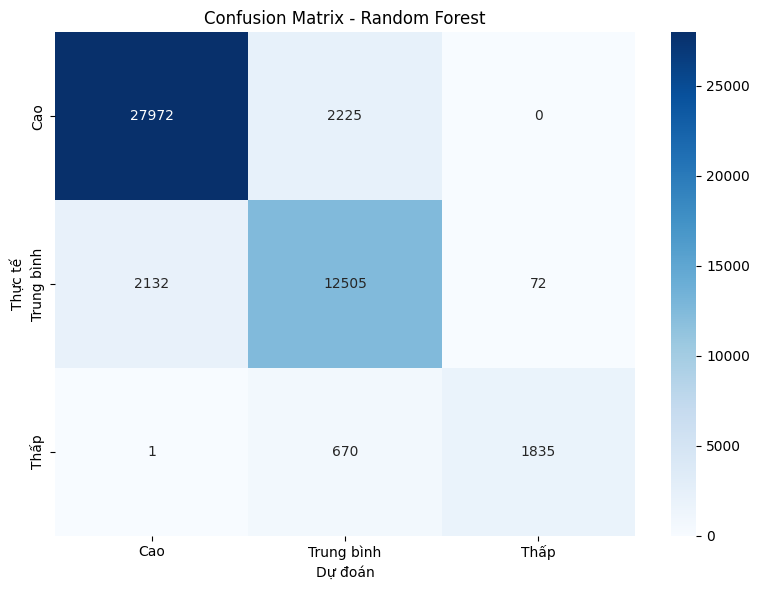


2. BÁO CÁO PHÂN LOẠI CHI TIẾT:
              precision    recall  f1-score   support

         Cao       0.93      0.93      0.93     30197
  Trung bình       0.81      0.85      0.83     14709
        Thấp       0.96      0.73      0.83      2506

    accuracy                           0.89     47412
   macro avg       0.90      0.84      0.86     47412
weighted avg       0.89      0.89      0.89     47412


3. ROC CURVES:


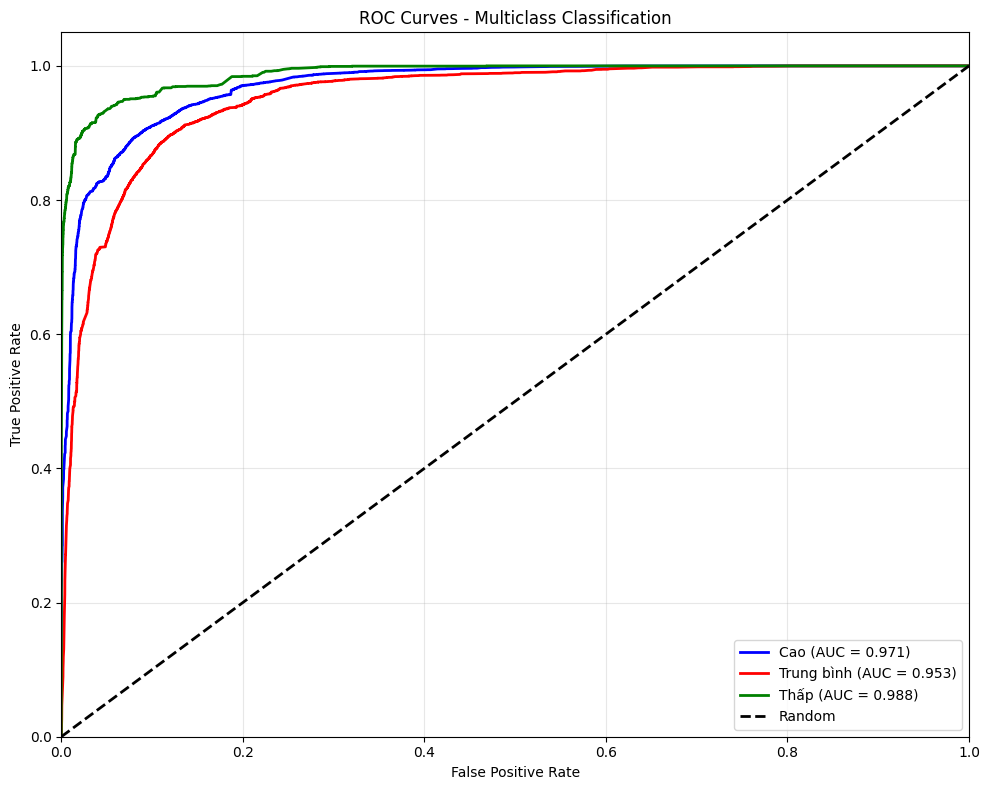


4. MACRO VÀ MICRO AVERAGES:
   Macro-average AUC: 0.9703
   Micro-average AUC: 0.9779

5. THỐNG KÊ CONFUSION MATRIX:
   Ma trận nhầm lẫn:
   [Cao]     [Trung bình] [Thấp]
   Cao: [27972  2225     0]
   Trung bình: [ 2132 12505    72]
   Thấp: [   1  670 1835]

   Tổng số mẫu: 47412
   Dự đoán đúng: 42312
   Độ chính xác: 0.8924

   Cao:
     Precision: 0.9291
     Recall: 0.9263
     F1-Score: 0.9277

   Trung bình:
     Precision: 0.8120
     Recall: 0.8502
     F1-Score: 0.8306

   Thấp:
     Precision: 0.9622
     Recall: 0.7322
     F1-Score: 0.8316


In [ ]:
# EVALUATE RANDOM FOREST MODEL

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST")
print("="*80)

# Evaluate Random Forest with confusion matrix and AUC
rf_cm, rf_roc_auc = detailed_model_evaluation(rf_predictions, "Random Forest")

# Display confusion matrix statistics
print("\n5. THỐNG KÊ CONFUSION MATRIX:")
print("   Ma trận nhầm lẫn:")
print("   [Cao]     [Trung bình] [Thấp]")
for i, row in enumerate(rf_cm):
    class_name = ["Cao", "Trung bình", "Thấp"][i]
    print(f"   {class_name}: {row}")

# Calculate metrics from confusion matrix
total_samples = np.sum(rf_cm)
correct_predictions = np.trace(rf_cm)
accuracy = correct_predictions / total_samples

print(f"\n   Tổng số mẫu: {total_samples}")
print(f"   Dự đoán đúng: {correct_predictions}")
print(f"   Độ chính xác: {accuracy:.4f}")

# Precision, Recall, F1 for each class
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    tp = rf_cm[i, i]
    fp = np.sum(rf_cm[:, i]) - tp
    fn = np.sum(rf_cm[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n   {class_name}:")
    print(f"     Precision: {precision:.4f}")
    print(f"     Recall: {recall:.4f}")
    print(f"     F1-Score: {f1:.4f}")


#### Nhận Xét  
**1. Confusion Matrix – Ma trận nhầm lẫn**

a) Nhận xét:

`Lớp “Cao”`:
- Dự đoán đúng 27.972 mẫu, sai 2.225 mẫu (chủ yếu bị nhầm sang “Trung bình”).
- → Mô hình phân biệt rất tốt lớp “Cao” với các lớp khác.

`Lớp “Trung bình”:`
- Dự đoán đúng 12.505 mẫu, sai 2.132 mẫu sang “Cao” và chỉ 72 mẫu sang “Thấp”.
- → Đây là lớp có độ chính xác khá cao, nhưng vẫn tồn tại một lượng nhỏ bị nhầm với “Cao”, có thể do đặc trưng giữa hai nhóm này tương đồng.

`Lớp “Thấp”:`
- Dự đoán đúng 1.835 mẫu, nhưng bị nhầm 670 mẫu sang “Trung bình” và 1 mẫu sang "Cao"
- → Điều này cho thấy mô hình khó phân biệt “Thấp” và “Trung bình”, có thể vì dữ liệu của lớp “Thấp” ít hơn hoặc có đặc trưng gần nhau.

b)Tổng kết:
- Nhìn chung, mô hình Random Forest hoạt động ổn định ở cả ba lớp, tuy nhiên có sự nhầm lẫn nhẹ giữa “Cao” và “Trung bình”, do hai nhóm này có đặc điểm khá tương đồng.

**2. ROC Curve – Đường cong ROC**

a) Nhận xét:

- AUC cho từng lớp:
    - “Cao”: 0.971
    - “Trung bình”: 0.953
    - “Thấp”: 0.988

- Các đường ROC đều nằm sát góc trên bên trái, chứng tỏ khả năng phân biệt giữa các lớp rất tốt.

- Lớp “Trung bình” có AUC thấp nhất (0.953), khớp với Confusion Matrix – lớp này là nơi dễ nhầm nhất.

b) Kết luận ROC:
- Các giá trị AUC đều trên 0.95, thể hiện khả năng phân loại rất tốt của mô hình, đặc biệt với lớp “Thấp” (AUC = 0.988).
- Lớp “Trung bình” có AUC thấp hơn một chút, phù hợp với việc bị nhầm lẫn nhẹ trong ma trận nhầm lẫn.

### `Logistic Regression` Model Evaluation


ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION

ĐÁNH GIÁ CHI TIẾT: Logistic Regression

1. CONFUSION MATRIX:


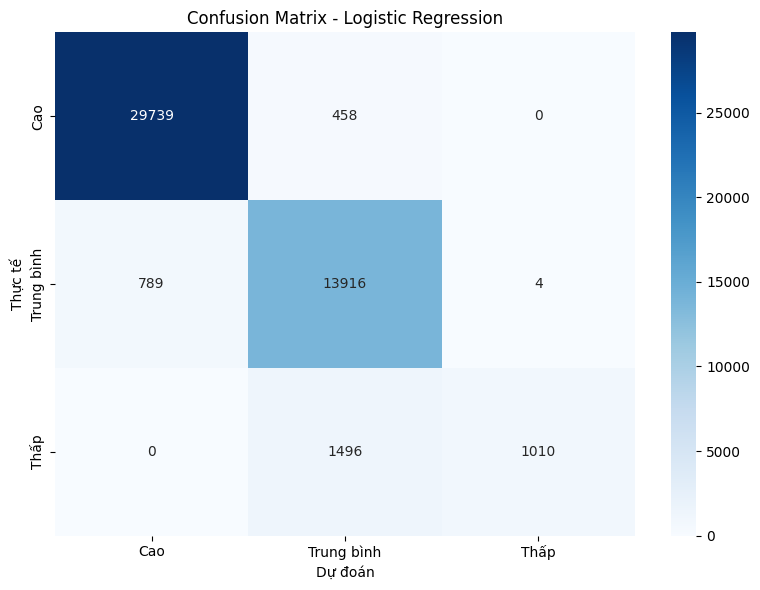


2. BÁO CÁO PHÂN LOẠI CHI TIẾT:
              precision    recall  f1-score   support

         Cao       0.97      0.98      0.98     30197
  Trung bình       0.88      0.95      0.91     14709
        Thấp       1.00      0.40      0.57      2506

    accuracy                           0.94     47412
   macro avg       0.95      0.78      0.82     47412
weighted avg       0.95      0.94      0.94     47412


3. ROC CURVES:


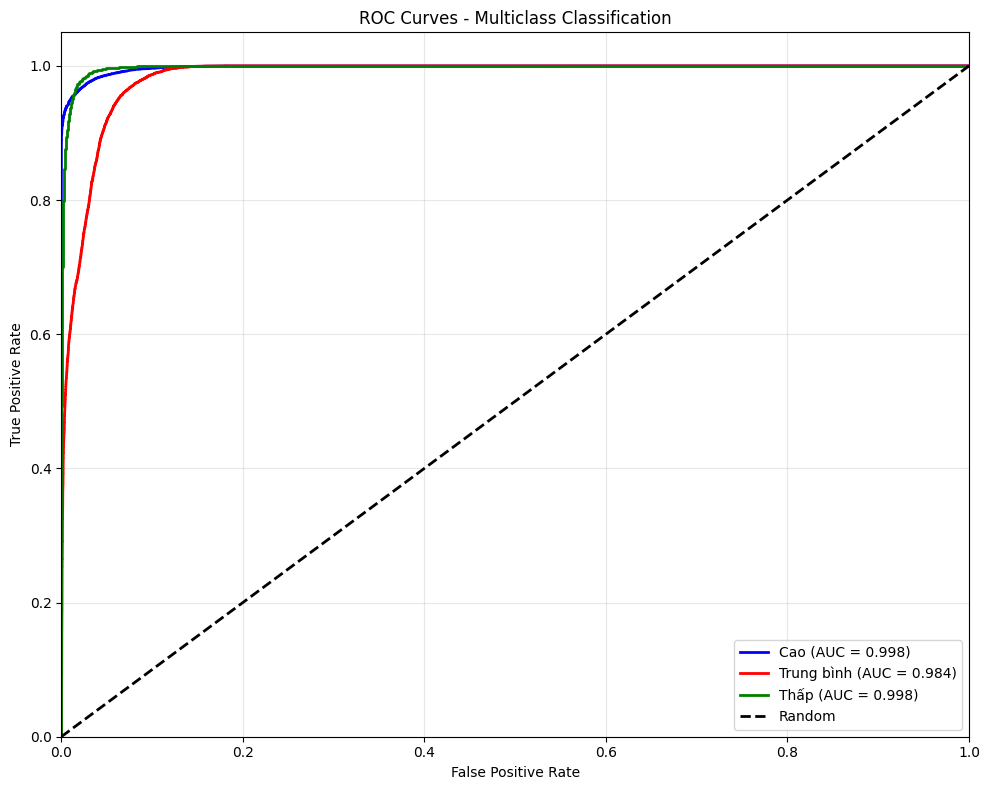


4. MACRO VÀ MICRO AVERAGES:
   Macro-average AUC: 0.9931
   Micro-average AUC: 0.9936

5. THỐNG KÊ CONFUSION MATRIX:
   Ma trận nhầm lẫn:
   [Cao]     [Trung bình] [Thấp]
   Cao: [29739   458     0]
   Trung bình: [  789 13916     4]
   Thấp: [   0 1496 1010]

   Tổng số mẫu: 47412
   Dự đoán đúng: 44665
   Độ chính xác: 0.9421

   Cao:
     Precision: 0.9742
     Recall: 0.9848
     F1-Score: 0.9795

   Trung bình:
     Precision: 0.8769
     Recall: 0.9461
     F1-Score: 0.9102

   Thấp:
     Precision: 0.9961
     Recall: 0.4030
     F1-Score: 0.5739


In [ ]:
# EVALUATE LOGISTIC REGRESSION MODEL

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION")
print("="*80)

# Evaluate Logistic Regression with confusion matrix and AUC
lr_cm, lr_roc_auc = detailed_model_evaluation(lr_predictions, "Logistic Regression")

# Display confusion matrix statistics
print("\n5. THỐNG KÊ CONFUSION MATRIX:")
print("   Ma trận nhầm lẫn:")
print("   [Cao]     [Trung bình] [Thấp]")
for i, row in enumerate(lr_cm):
    class_name = ["Cao", "Trung bình", "Thấp"][i]
    print(f"   {class_name}: {row}")

# Calculate metrics from confusion matrix
total_samples = np.sum(lr_cm)
correct_predictions = np.trace(lr_cm)
accuracy = correct_predictions / total_samples

print(f"\n   Tổng số mẫu: {total_samples}")
print(f"   Dự đoán đúng: {correct_predictions}")
print(f"   Độ chính xác: {accuracy:.4f}")

# Precision, Recall, F1 for each class
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    tp = lr_cm[i, i]
    fp = np.sum(lr_cm[:, i]) - tp
    fn = np.sum(lr_cm[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n   {class_name}:")
    print(f"     Precision: {precision:.4f}")
    print(f"     Recall: {recall:.4f}")
    print(f"     F1-Score: {f1:.4f}")


#### Nhận Xét  
**1. Confusion Matrix – Ma trận nhầm lẫn**

a) Nhận xét:

`Lớp “Cao”`:
- Dự đoán đúng 29,739 mẫu, sai 458 mẫu (chủ yếu bị nhầm sang “Trung bình”).
- → Mô hình phân biệt rất tốt lớp “Cao” với các lớp khác.

`Lớp “Trung bình”:`
- Dự đoán đúng 13,916 mẫu, sai 789 mẫu sang “Cao” và chỉ 4 mẫu sang “Thấp”.
- → Đây là lớp có độ chính xác khá cao, nhưng vẫn tồn tại một lượng nhỏ bị nhầm với “Cao”, có thể do đặc trưng giữa hai nhóm này tương đồng.

`Lớp “Thấp”:`
- Dự đoán đúng 1,010 mẫu, nhưng bị nhầm 1,496 mẫu sang “Trung bình”.
- → Điều này cho thấy mô hình khó phân biệt “Thấp” và “Trung bình”, có thể vì dữ liệu của lớp “Thấp” ít hơn hoặc có đặc trưng gần nhau.

b)Tổng kết:
- Độ chính xác tổng thể cao, nhưng cần cải thiện độ nhạy (recall) cho lớp “Thấp”.
- Mô hình Logistic Regression ổn định và ít sai lệch nghiêm trọng, chỉ gặp khó với ranh giới giữa “Thấp” và “Trung bình”.

**2. ROC Curve – Đường cong ROC**

a) Nhận xét:

- AUC cho từng lớp:
    - “Cao”: 0.998
    - “Trung bình”: 0.984
    - “Thấp”: 0.998

- Các đường ROC đều nằm sát góc trên bên trái, chứng tỏ khả năng phân biệt giữa các lớp rất tốt.

- Lớp “Trung bình” có AUC thấp nhất (0.984), khớp với Confusion Matrix – lớp này là nơi dễ nhầm nhất.

b) Kết luận ROC:

- Tất cả AUC > 0.98 → mô hình Logistic Regression có hiệu suất phân biệt rất cao.

- Mô hình đủ mạnh để dùng trong dự đoán thực tế, chỉ cần tinh chỉnh thêm cho lớp “Thấp”.

### Compare Models With Auc Scores


SO SÁNH MÔ HÌNH VỚI AUC SCORES

SO SÁNH AUC SCORES:
--------------------------------------------------
Random Forest:
  - Macro-average AUC: 0.9703
  - Cao AUC: 0.9707
  - Trung bình AUC: 0.9526
  - Thấp AUC: 0.9877

Logistic Regression:
  - Macro-average AUC: 0.9931
  - Cao AUC: 0.9977
  - Trung bình AUC: 0.9840
  - Thấp AUC: 0.9975

KẾT LUẬN DỰA TRÊN AUC:
✓ Mô hình tốt nhất theo AUC: Logistic Regression
  Macro-average AUC: 0.9931
  Chênh lệch: 0.0228


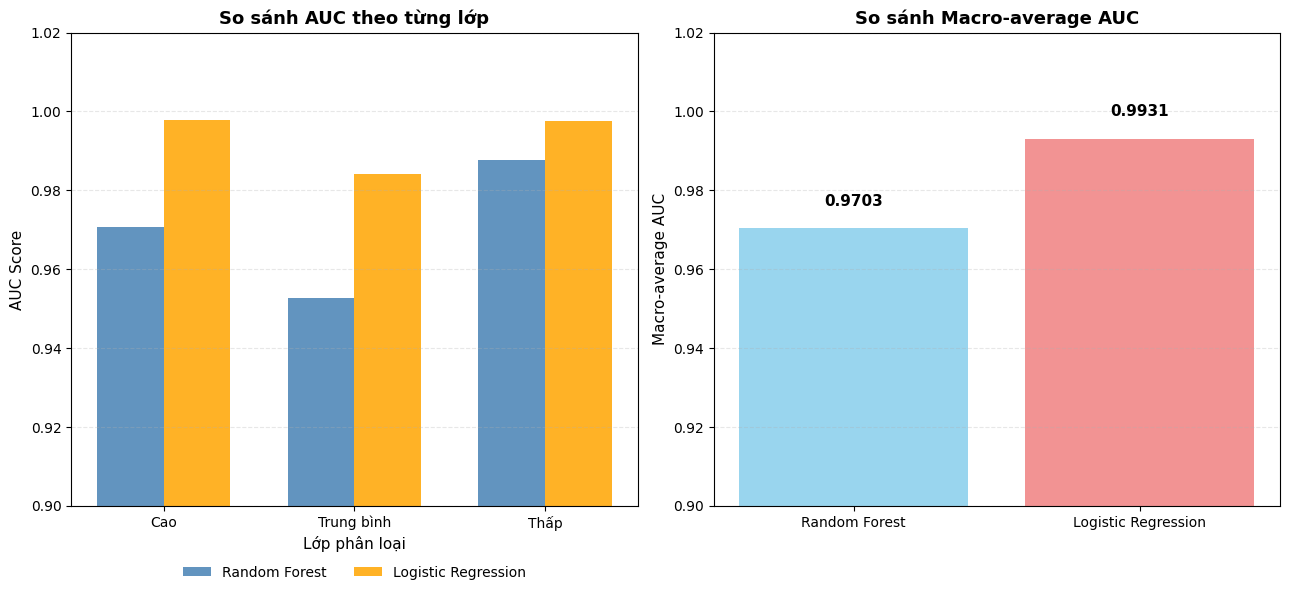

In [ ]:
# COMPARE MODELS WITH AUC SCORES
print("\n" + "="*80)
print("SO SÁNH MÔ HÌNH VỚI AUC SCORES")
print("="*80)

# Compare AUC scores
print("\nSO SÁNH AUC SCORES:")
print("-" * 50)

# Random Forest AUC
rf_macro_auc = np.mean(list(rf_roc_auc.values()))
print(f"Random Forest:")
print(f"  - Macro-average AUC: {rf_macro_auc:.4f}")
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    print(f"  - {class_name} AUC: {rf_roc_auc[i]:.4f}")

print()

# Logistic Regression AUC
lr_macro_auc = np.mean(list(lr_roc_auc.values()))
print(f"Logistic Regression:")
print(f"  - Macro-average AUC: {lr_macro_auc:.4f}")
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    print(f"  - {class_name} AUC: {lr_roc_auc[i]:.4f}")

# Determine best model based on AUC
print(f"\n{'='*50}")
print("KẾT LUẬN DỰA TRÊN AUC:")
print(f"{'='*50}")

if lr_macro_auc > rf_macro_auc:
    best_auc_model = "Logistic Regression"
    best_auc_score = lr_macro_auc
    print(f"✓ Mô hình tốt nhất theo AUC: {best_auc_model}")
    print(f"  Macro-average AUC: {best_auc_score:.4f}")
    print(f"  Chênh lệch: {lr_macro_auc - rf_macro_auc:.4f}")
else:
    best_auc_model = "Random Forest"
    best_auc_score = rf_macro_auc
    print(f"✓ Mô hình tốt nhất theo AUC: {best_auc_model}")
    print(f"  Macro-average AUC: {best_auc_score:.4f}")
    print(f"  Chênh lệch: {rf_macro_auc - lr_macro_auc:.4f}")

# Plot AUC comparison charts
plt.figure(figsize=(13, 6))

# Subplot 1: Compare AUC by class
plt.subplot(1, 2, 1)
classes = ["Cao", "Trung bình", "Thấp"]
rf_aucs = [rf_roc_auc[i] for i in range(3)]
lr_aucs = [lr_roc_auc[i] for i in range(3)]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, rf_aucs, width, label='Random Forest', alpha=0.85, color='steelblue')
plt.bar(x + width/2, lr_aucs, width, label='Logistic Regression', alpha=0.85, color='orange')

plt.xlabel('Lớp phân loại', fontsize=11)
plt.ylabel('AUC Score', fontsize=11)
plt.title('So sánh AUC theo từng lớp', fontsize=13, weight='bold')
plt.xticks(x, classes)
plt.ylim(0.9, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, frameon=False)

# Subplot 2: Compare Macro-average AUC
plt.subplot(1, 2, 2)
models = ['Random Forest', 'Logistic Regression']
macro_aucs = [rf_macro_auc, lr_macro_auc]
colors = ['skyblue', 'lightcoral']

bars = plt.bar(models, macro_aucs, color=colors, alpha=0.85)
plt.ylabel('Macro-average AUC', fontsize=11)
plt.title('So sánh Macro-average AUC', fontsize=13, weight='bold')
plt.ylim(0.9, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# # Add value labels on bars
for bar, auc in zip(bars, macro_aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{auc:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.subplots_adjust(wspace=0.35, bottom=0.18)
plt.tight_layout()
plt.show()

#### Nhận Xét  
**1. Biểu đồ bên trái – So sánh AUC theo từng lớp**

a) Nhận Xét Chi Tiết
| Lớp phân loại  | Random Forest | Logistic Regression | Mô hình tốt hơn       |
| -------------- | ------------- | ------------------- | --------------------- |
| **Cao**        | ≈ 0.971       | ≈ 0.999             |  Logistic Regression |
| **Trung bình** | ≈ 0.950       | ≈ 0.983             |  Logistic Regression |
| **Thấp**       | ≈ 0.989       | ≈ 0.999             |  Logistic Regression |

b) Nhận xét tổng quát:
- Cả hai mô hình đều đạt AUC > 0.94 cho tất cả các lớp, chứng tỏ khả năng phân biệt giữa các nhãn là rất tốt.
- Tuy nhiên, Logistic Regression vượt trội hơn rõ rệt ở cả ba lớp, đặc biệt là lớp “Trung bình” — vốn là nhóm thường khó phân loại nhất.
- Random Forest có xu hướng bị giảm nhẹ AUC ở lớp “Trung bình”, cho thấy nó có thể bị ảnh hưởng bởi sự mất cân bằng hoặc trùng lặp đặc trưng giữa các nhóm.

 **2. Biểu đồ bên phải – So sánh Macro-average AUC**

a) Giá trị trung bình:
- Random Forest: 0.9703
- Logistic Regression: 0.9931

b) Nhận xét:
- Logistic Regression cao hơn ~0.023 điểm (2.3%) so với Random Forest.
- Điều này nghĩa là Logistic Regression có hiệu năng tổng thể ổn định và chính xác hơn trên toàn bộ các lớp.
- Mức chênh lệch nhỏ nhưng rõ ràng về mặt thống kê, cho thấy Logistic Regression là mô hình tổng quát hóa tốt hơn trên dữ liệu này.


## Find the best model

In [ ]:
import builtins  # dùng max gốc của Python

models_info = [
    {
        "name": "Random Forest",
        "accuracy": rf_accuracy,
        "params": {
            "numTrees": best_rf_model.getNumTrees,
            "maxDepth": best_rf_model.getOrDefault("maxDepth"),
            "maxBins": best_rf_model.getOrDefault("maxBins")
        }
    },
    {
        "name": "Logistic Regression",
        "accuracy": lr_accuracy,
        "params": {
            "regParam": best_lr_model.getRegParam(),
            "elasticNetParam": best_lr_model.getElasticNetParam()
        }
    }
]

# Dùng builtins.max
best_model = builtins.max(models_info, key=lambda m: m["accuracy"])

print("\n So sánh mô hình:")
for m in models_info:
    marker = "" if m["name"] == best_model["name"] else "  "
    print(f"{marker} {m['name']}: Accuracy = {m['accuracy']:.4f}")
    for k, v in m["params"].items():
        print(f"     {k}: {v}")
    print("-" * 50)

print(f"\n Mô hình tốt nhất: {best_model['name']} (Độ chính xác = {best_model['accuracy']:.4f})")
print("  Siêu tham số tối ưu:")
for k, v in best_model["params"].items():
    print(f"   {k}: {v}")



 So sánh mô hình:
   Random Forest: Accuracy = 0.9794
     numTrees: 100
     maxDepth: 15
     maxBins: 64
--------------------------------------------------
 Logistic Regression: Accuracy = 0.9950
     regParam: 0.001
     elasticNetParam: 1.0
--------------------------------------------------

 Mô hình tốt nhất: Logistic Regression (Độ chính xác = 0.9950)
  Siêu tham số tối ưu:
   regParam: 0.001
   elasticNetParam: 1.0


### Nhận xét so sánh hai mô hình

- `Random Forest` sau khi tối ưu (numTrees=100, maxDepth=15, maxBins=64) đạt Accuracy = 0.9794, thể hiện khả năng phân loại chính xác và ổn định. Mô hình này mạnh trong việc xử lý quan hệ phi tuyến và dữ liệu phức tạp, tuy nhiên vẫn có giới hạn khi dữ liệu có xu hướng tuyến tính rõ ràng.
- `Logistic Regression` với siêu tham số tối ưu (regParam=0.001, elasticNetParam=1.0) đạt Accuracy = 0.9950, cao hơn khoảng 1.5% so với Random Forest. Điều này cho thấy Logistic Regression phù hợp hơn với đặc trưng của bộ dữ liệu, đồng thời đơn giản, dễ huấn luyện và tổng quát hóa tốt.
- Dựa trên kết quả đánh giá, mô hình Logistic Regression được chọn là mô hình tốt nhất, vì đạt độ chính xác cao nhất và thể hiện hiệu suất ổn định trên các chỉ số đánh giá.

## Predictions in Test

In [ ]:
from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import StringType

# Map numeric labels to string labels (based on trained StringIndexer order)
label_mapping = {0.0: "Cao", 1.0: "Trung bình", 2.0: "Thấp"}
map_label_udf = udf(lambda x: label_mapping.get(x, "Không rõ"), StringType())

# Get 10 random samples from test set
sample_test = test_data.orderBy(rand()).limit(10)

# Determine the best model
if best_model["name"] == "Random Forest":
    best_model_object = best_rf_model
elif best_model["name"] == "Logistic Regression":
    best_model_object = best_lr_model
else:
    raise ValueError("Không xác định được mô hình tốt nhất!")

# Make predictions
sample_predictions = best_model_object.transform(sample_test)

# Add true and predicted labels in string format
sample_with_labels = (
    sample_predictions
    .withColumn("Label_thật", map_label_udf(col("label")))
    .withColumn("Dự_đoán", map_label_udf(col("prediction")))
)

# Display key columns
columns_to_show = [
    "city1", "city2", "passengers", "fare", "nsmiles",
    "large_ms", "lf_ms", "fare_lg", "fare_low",
    "Label_thật", "Dự_đoán"
]

print(f"\n Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: {best_model['name']}")
sample_with_labels.select(columns_to_show).show(truncate=False)



 Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: Logistic Regression
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|city1                                |city2                                |passengers|fare  |nsmiles|large_ms|lf_ms |fare_lg|fare_low|Label_thật|Dự_đoán   |
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|Chicago, IL                          |Tulsa, OK                            |219       |159.12|585    |0.68    |0.28  |158.78 |157.54  |Cao       |Cao       |
|Miami, FL (Metropolitan Area)        |Pittsburgh, PA                       |218       |168.14|1013   |0.77    |0.04  |171.81 |109.38  |Cao       |Cao       |
|Indianapolis, IN                     |New York City, NY (Metropolitan Area)|447       |240.15|700    |0.77    |0.11  |250.35 |200.6  